In [2]:
#!/usr/bin/env python
# coding: utf-8

from datetime import datetime
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
import pandas as pd

##########################################################################################
''' Marker list '''
marker_list = ['d', 'o', 'x', 'v', '^', '<', '>', 's', '8', 'p']

''' Linewidth '''
lw = 5

''' Color list '''
## Manually set color list
# color_list = ["blue", "orange", "green", "purple", "brown", "#FBDD7E", "cyan", "#C20078", "#FAC205", "gray",  "#06C2AC", "#FFFF14", "#E6DAA6","olive", "#76FF7B", "pink", "#BC8F6", "#AAA662"]
## Tableau color list
color_dict = mcolors.TABLEAU_COLORS
color_list = list()
for name in color_dict:
    color_list.append(color_dict[name])

''' Line style '''
line_style_list = ["solid", "dashdot", "dashed", 'dotted']
##########################################################################################

# routing_algorithm = ["RoundRobin-LCLB", "RoundRobin-MCLB", "RoundRobin-heuristic_TE"]
routing_algorithm = ["RoundRobin-LCLB", "RoundRobin-MCLB", "RoundRobin-heuristic_TE", "RoundRobin-capacity_TE"]
# routing_algorithm = ["RoundRobin-MCLB", "RoundRobin-heuristic_TE"]
cluster_id = [0, 1]


In [3]:
def plot_latency_cdf(latency_dict_):
    fig = plt.figure()
    color_idx = 0
    ls_idx = 0
    for key in latency_dict_:
        x_0 = np.sort(latency_dict_[key])
        num_data_point_0 = len(latency_dict_[key])
        y_0 = np.arange(num_data_point_0) / float(num_data_point_0)
        plt.plot(x_0, y_0, label=key, color=color_list[color_idx], linewidth=lw, linestyle=line_style_list[ls_idx])
        color_idx += 1
        ls_idx += 1
    # plt.title("cluster", fontsize=30)
    plt.xlim(0, )
    plt.xlabel('Request latency(ms)', fontsize=30)
    plt.ylabel('CDF', fontsize=25)
    # plt.legend(loc="lower right", fontsize=14, frameon = False)
    plt.legend(loc="lower right", fontsize=16)
    plt.xticks(fontsize=20, rotation=45)
    plt.yticks(fontsize=20)
    # plt.savefig(path+workload+"-"+cluster_name+"-latency_cdf.pdf", dpi=100, bbox_inches='tight')
    plt.show()
    plt.close(fig)
    

def find_tail_idx(data, tail=0.95):
    tail_idx = 0
    for i in range(len(data)):
        if data[i] >= tail:
            tail_idx = i
            break
    print("{}, tail_idx: {}".format("???", tail_idx))
    return tail_idx
    
def plot_tail_latency_cdf(latency_dict_):
    fig = plt.figure()     
    color_idx = 0
    ls_idx = 0
    for key in latency_dict_:
        num_data_point_0 = len(latency_dict_[key])
        y_0 = np.arange(num_data_point_0) / float(num_data_point_0)
        tail = 0.95
        tail_idx = find_tail_idx(y_0, tail)
        y_tail = y_0[tail_idx:]
        x_0 = np.sort(latency_dict_[key])
        x_tail = x_0[tail_idx:]
        plt.plot(x_tail, y_tail, label=key, color=color_list[color_idx], linewidth=lw, linestyle=line_style_list[ls_idx])
        color_idx += 1
        ls_idx += 1
    # plt.title("Bursty cluster", fontsize=30)
    plt.xlim(0, )
    plt.xlabel('Request latency(ms)', fontsize=30)
    plt.ylabel('CDF', fontsize=25)
    # plt.legend(loc="lower right", fontsize=14, frameon = False)
    plt.legend(loc="lower right", fontsize=16)
    plt.xticks(fontsize=20, rotation=45)
    plt.yticks(fontsize=20)
    # plt.savefig(path+workload+"-"+cluster_name+"-tail_latency_cdf.pdf", dpi=100, bbox_inches='tight')
    plt.show()
    plt.close(fig)
    
    
def parse_latency_file(f_):
    data = f_.readlines()
    latency = list()
    for elem in data:
        latency.append(float(elem.strip()))
    return latency

def latency_file_to_df(f_):
    df = pd.read_csv(f_, header=None)
    df.columns=["request_latency"]
    df = df.sort_values(by=["request_latency"])
    df = df.reset_index(drop="True")
    return df


def print_statistics(latency_dict_):
    for key in latency_dict_:
        print("="*30)
        print(key)
        print("- Avg: {}".format(round(np.mean(latency_dict_[key]), 2)))
        print("- 50p: {}".format(round(np.percentile(latency_dict_[key], 50), 2)))
        print("- 90p: {}".format(round(np.percentile(latency_dict_[key], 90), 2)))
        print("- 95p: {}".format(round(np.percentile(latency_dict_[key], 95), 2)))
        print("- 99p: {}".format(round(np.percentile(latency_dict_[key], 99), 2)))
        print("- 99.9p: {}".format(round(np.percentile(latency_dict_[key], 99.9), 2)))

def plot_quantile(ser):
    q_list = [0.5, 0.9, 0.95, 0.99, 0.999]
    # q_list = [0.5, 0.9, 0.95, 0.99]
    quantiles = list()
    for q in q_list:
        temp = int(ser.quantile(q))
        quantiles.append(temp)
        print("{}: {}".format(str(q), temp))
    return quantiles

def parse_metadata(path):
    f_ = open(path, 'r')
    lines = f_.readlines()
    application = lines[0].split(":")[-1].strip()
    load_balancer = lines[1].split(":")[-1].strip()
    routing = lines[2].split(":")[-1].strip()
    return application, load_balancer, routing

def plot_latency(common_path, ra_ = list()):
    c0_files = list()
    c1_files = list()
    metadata_files = list()
    if len(ra_) > 0:
        ra = ra_
    else:
        ra = routing_algorithm
    for routing in ra:
        metad = common_path + routing + "/metadata.txt"
        c0_f_ = common_path + routing + "/latency-cluster_0.txt"
        c1_f_ = common_path + routing + "/latency-cluster_1.txt"
        c0_files.append(c0_f_)
        c1_files.append(c1_f_)
        # metadata_files.append(metad)
        try:
            assert c0_f_.split(".")[-1] == "txt" and c0_f_.split("/")[-1].split("-")[0] == "latency"
            assert c1_f_.split(".")[-1] == "txt" and c1_f_.split("/")[-1].split("-")[0] == "latency"
        except:
            print("invalid file name: {}".format(c0_f_))
            print("invalid file name: {}".format(c1_f_))
            exit()

    latency_files = [c0_files, c1_files]
    qt_list = list()
    cdf_list = list()
    df_dict = dict()
    for cid in cluster_id:
        for i in range(len(ra)):
            file_ = open(latency_files[cid][i], 'r')
            df = latency_file_to_df(file_)
            df_dict[ra[i]+str(cid)] = df # L0, M0, T0, L1, M1, T1
            # print("{}, {}".format("Cluster"+str(cid), ra[i]))
            # qt_list.append(plot_quantile(df["request_latency"]))
            cdf = df['request_latency'].value_counts().sort_index().cumsum() / len(df)
            cdf_list.append(cdf) # L0, M0, T0, L1, M1, T1
    
    
    fig = plt.figure(figsize=(10, 3.5))
    subplot_pos = 1
    ax1 = fig.add_subplot(1,3, subplot_pos) # (row, col, the position of the current plot)
    ## Overall performance
    xmin = list()
    xmax = list()
    q_ = [0.95, 1.0]
    for routing in ra:
        temp = list()
        for cid in cluster_id:
            temp.append(df_dict[routing+str(cid)])
        merged_df = pd.concat(temp, ignore_index=True)
        cdf = merged_df['request_latency'].value_counts().sort_index().cumsum() / len(merged_df)
        cdf.plot(kind='line', label=routing)
        max_ = np.percentile(cdf.index, 100)
        min_ = np.percentile(cdf.index, 0)
        xmax.append(max_)
        xmin.append(min_)
        print("{} agg p99: {}".format(routing, np.percentile(cdf.index, 99)))
        print("{} agg p999: {}".format(routing, np.percentile(cdf.index, 99.9)))
        print("{} agg max: {}".format(routing, max_))
    # plt.xlim(min(xmin)-100, min(xmax)+100)
    # plt.ylim(q_[0], q_[1]+0.001)
    # plt.tick_params(axis='y', labelsize=10)
    # plt.tick_params(axis='x', labelsize=10)
    # plt.xlabel('Request latency(ms)', fontsize=10)
    # plt.ylabel('CDF', fontsize=10)
    # plt.legend(loc="lower right", fontsize=10)
    # plt.title("Overall perf", fontsize=10)
    
    # ax1.set_xlim(min(xmin)-100, min(xmax)+100)
    if max(xmax) > 500:
        # ax1.set_xlim(0, xmax[0])
        # ax1.set_xlim(0, max(xmax))
        ax1.set_xlim(0, 500)
    else:
        ax1.set_xlim(0, max(xmax))
    ax1.set_ylim(q_[0], q_[1])
    ax1.tick_params(axis='y', labelsize=10)
    ax1.tick_params(axis='x', labelsize=10)
    ax1.set_xlabel('Request latency(ms)', fontsize=10)
    ax1.set_ylabel('CDF', fontsize=10)
    # ax1.legend(loc="lower right", fontsize=10)
    ax1.set_title("Overall perf", fontsize=10)
    subplot_pos += 1
    
    idx=0
    for cid in cluster_id:
        xmin = list()
        xmax = list()
        ax1 = fig.add_subplot(1,3, subplot_pos) # (row, col, the position of the current plot)
        for routing in ra:
            cdf_list[idx].plot(kind='line', label=routing)
            max_ = np.percentile(cdf_list[idx].index, 100)
            min_ = np.percentile(cdf_list[idx].index, 0)
            xmax.append(max_)
            xmin.append(min_)
            print("{} cluster {} p99: {}".format(routing, cid, np.percentile(cdf_list[idx].index, 99)))
            print("{} cluster {} p999: {}".format(routing, cid, np.percentile(cdf_list[idx].index, 99.9)))
            print("{} cluster {} max: {}".format(routing, cid, max_))
            idx+=1
        if max(xmax) > 500:
            # ax1.set_xlim(0, max(xmax))
            ax1.set_xlim(0, 500)
        else:
            ax1.set_xlim(0, max(xmax))
        ax1.set_ylim(q_[0], q_[1])
        ax1.tick_params(axis='y', labelsize=10)
        ax1.tick_params(axis='x', labelsize=10)
        ax1.set_xlabel('Request latency(ms)', fontsize=10)
        ax1.set_ylabel('CDF', fontsize=10)
        # ax1.legend(loc="lower right", fontsize=10)
        ax1.set_title("Cluster"+str(cid) + ", " + str(q_[0]), fontsize=10)
        subplot_pos += 1
    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles, labels, bbox_to_anchor=(0.5, 1.1), loc='upper center', ncol=3)
    fig.tight_layout()
    plt.show()
    plt.close()

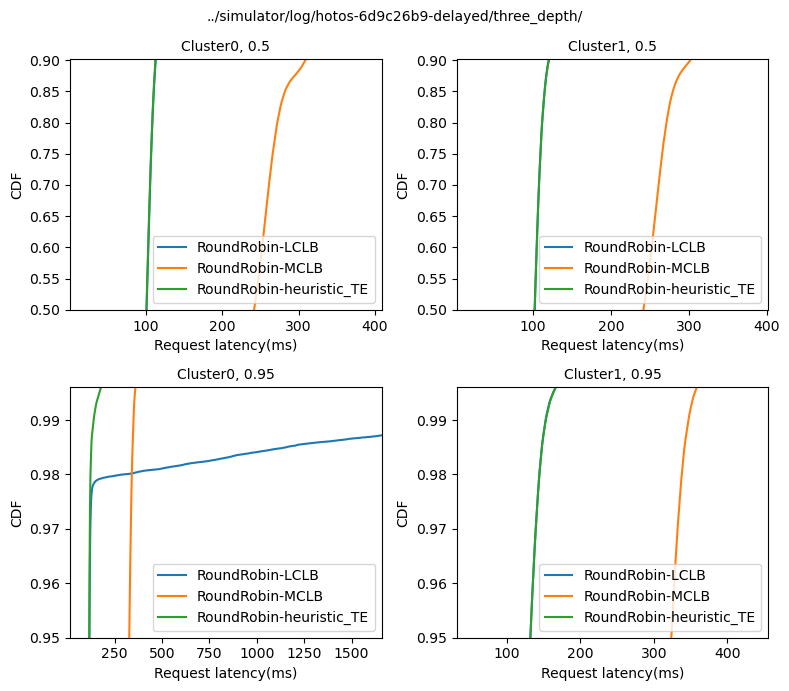

In [33]:
common_path="../simulator/log/hotos-6d9c26b9-delayed/three_depth/"
plot_latency(common_path)

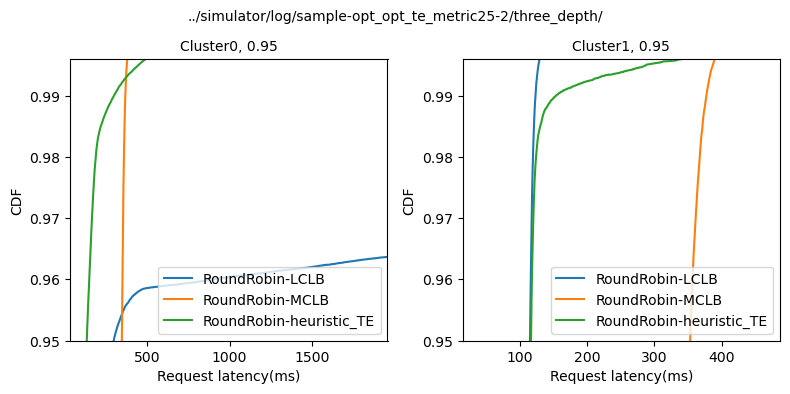

In [63]:
common_path="../simulator/log/sample-opt_opt_te_metric25-2/three_depth/"
plot_latency(common_path)

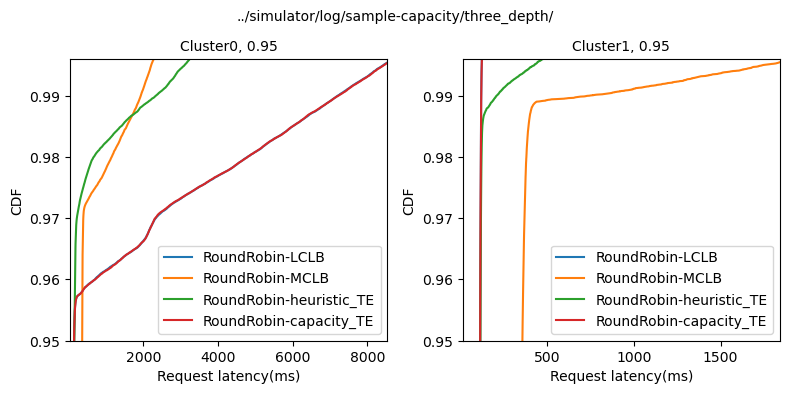

In [64]:
common_path="../simulator/log/sample-capacity/three_depth/"
plot_latency(common_path, ["RoundRobin-capacity_TE"])

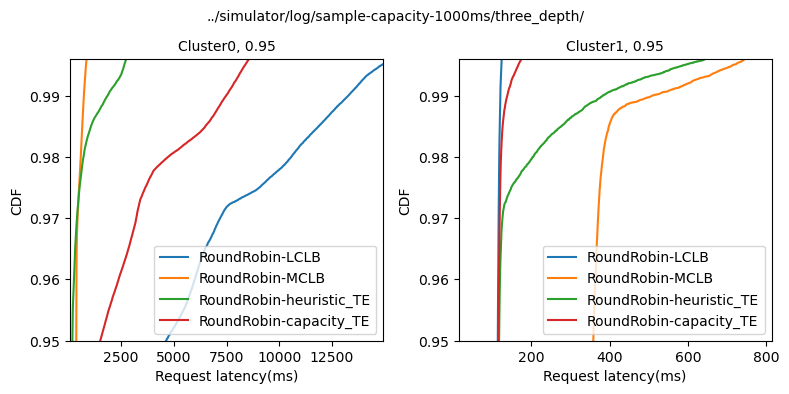

In [69]:
common_path="../simulator/log/sample-capacity-1000ms/three_depth/"
plot_latency(common_path, ["RoundRobin-capacity_TE"])
# plot_latency(common_path)

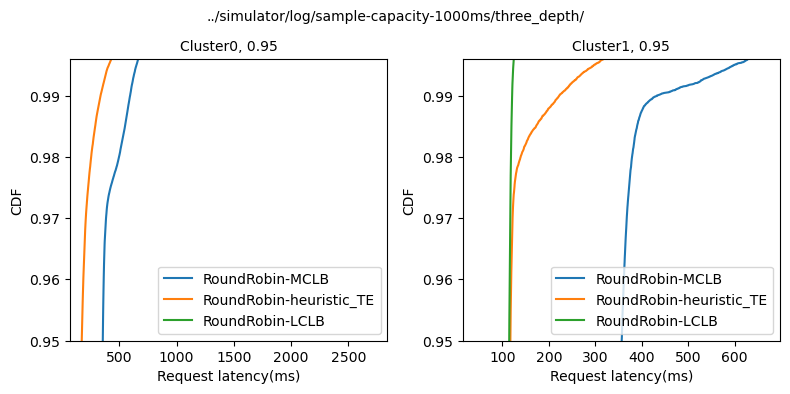

In [77]:
common_path="../simulator/log/sample-capacity-1000ms/three_depth/"
plot_latency(common_path, ["RoundRobin-MCLB", "RoundRobin-heuristic_TE", "RoundRobin-LCLB", ]
)
# plot_latency(common_path)

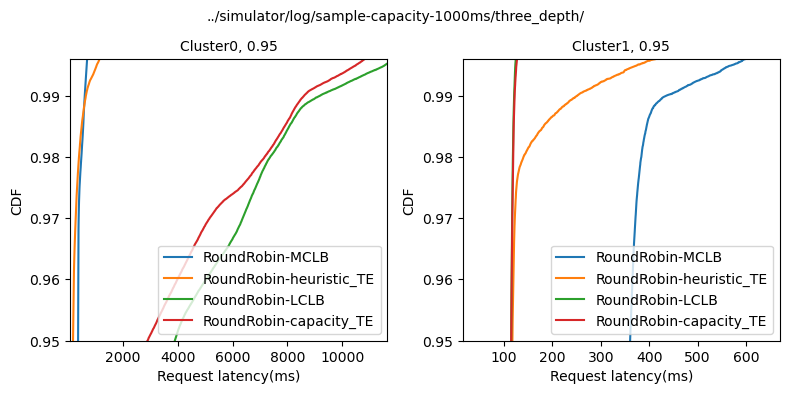

In [79]:
common_path="../simulator/log/sample-capacity-1000ms/three_depth/"
plot_latency(common_path, ["RoundRobin-MCLB", "RoundRobin-heuristic_TE", "RoundRobin-LCLB", "RoundRobin-capacity_TE"])
# plot_latency(common_path)

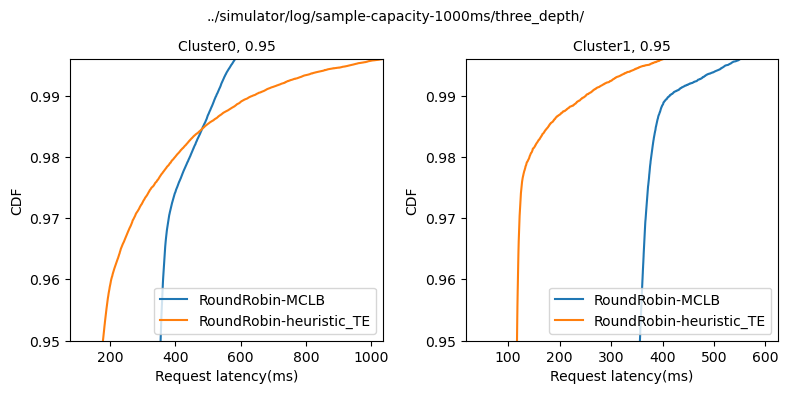

In [82]:
common_path="../simulator/log/sample-capacity-1000ms/three_depth/"
plot_latency(common_path, ["RoundRobin-MCLB", "RoundRobin-heuristic_TE"])
# plot_latency(common_path)

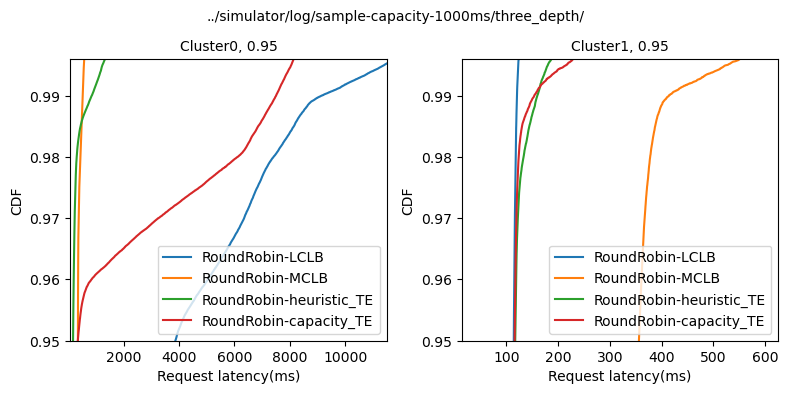

In [88]:
common_path="../simulator/log/sample-capacity-1000ms/three_depth/"
# plot_latency(common_path, ["RoundRobin-MCLB", "RoundRobin-heuristic_TE"])
plot_latency(common_path)

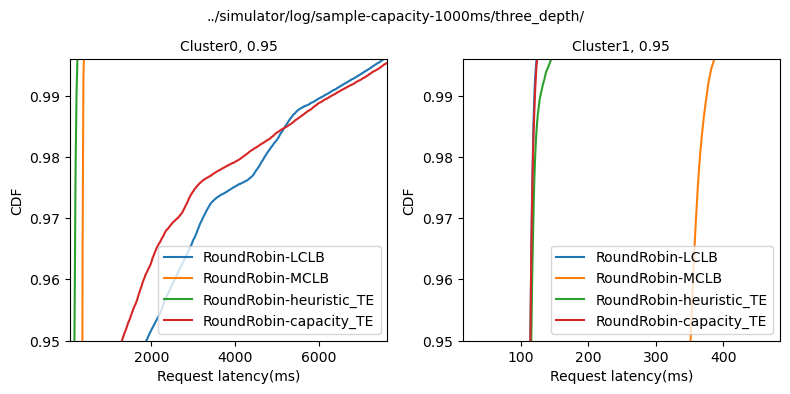

In [93]:
common_path="../simulator/log/sample-capacity-1000ms/three_depth/"
# plot_latency(common_path, ["RoundRobin-LCLB", "RoundRobin-MCLB", "RoundRobin-heuristic_TE"])
plot_latency(common_path)

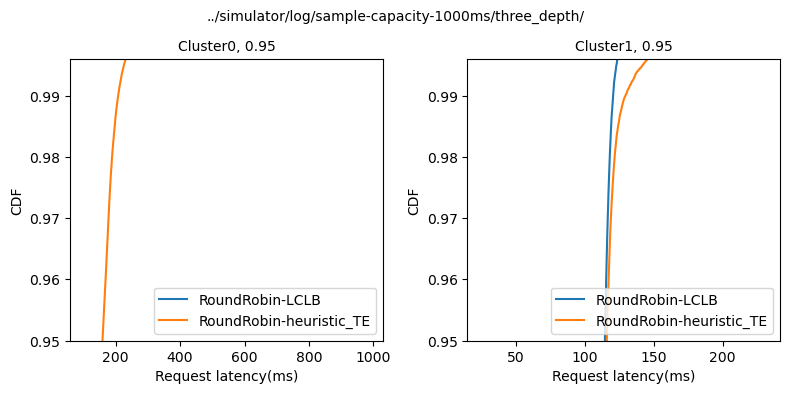

In [97]:
common_path="../simulator/log/sample-capacity-1000ms/three_depth/"
plot_latency(common_path, ["RoundRobin-LCLB", "RoundRobin-heuristic_TE"])
# plot_latency(common_path)

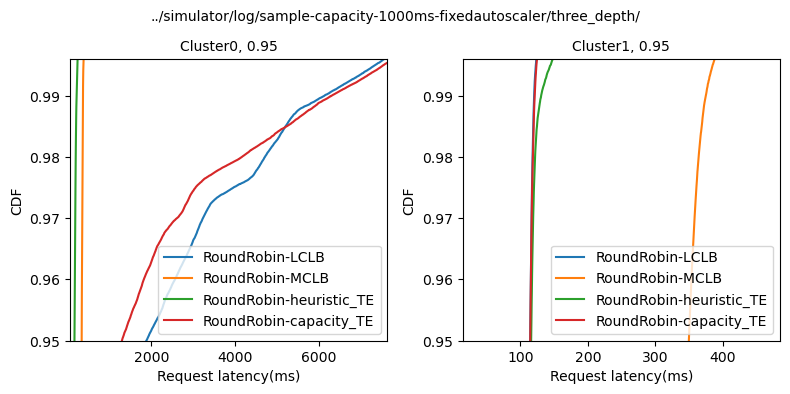

In [99]:
common_path="../simulator/log/sample-capacity-1000ms-fixedautoscaler/three_depth/"
# plot_latency(common_path, ["RoundRobin-LCLB", "RoundRobin-heuristic_TE"])
plot_latency(common_path)

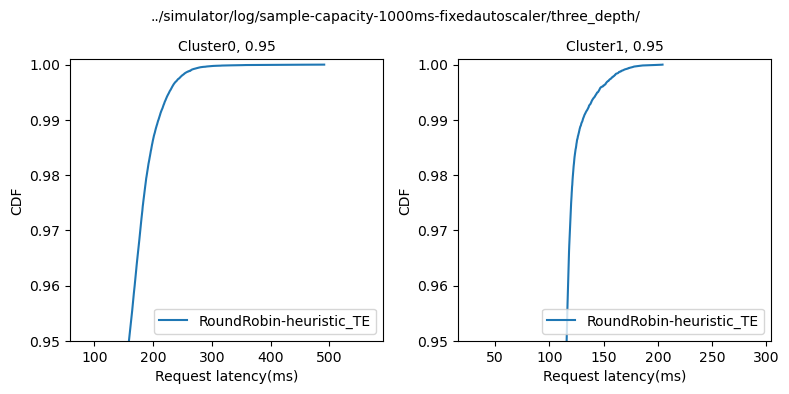

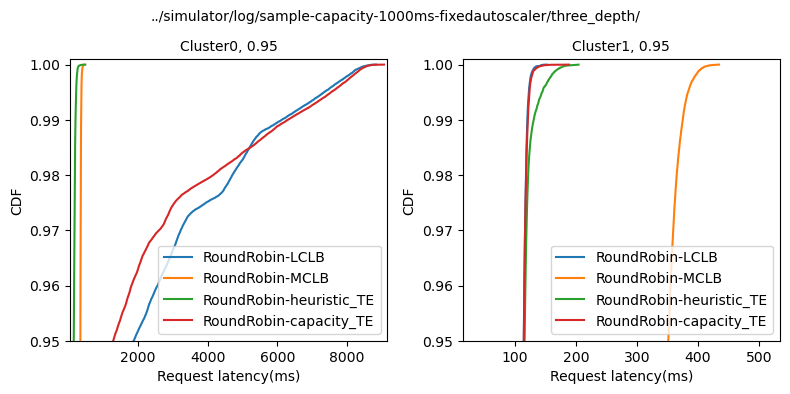

In [316]:
common_path="../simulator/log/sample-capacity-1000ms-fixedautoscaler/three_depth/"
plot_latency(common_path, ["RoundRobin-heuristic_TE"])
plot_latency(common_path)

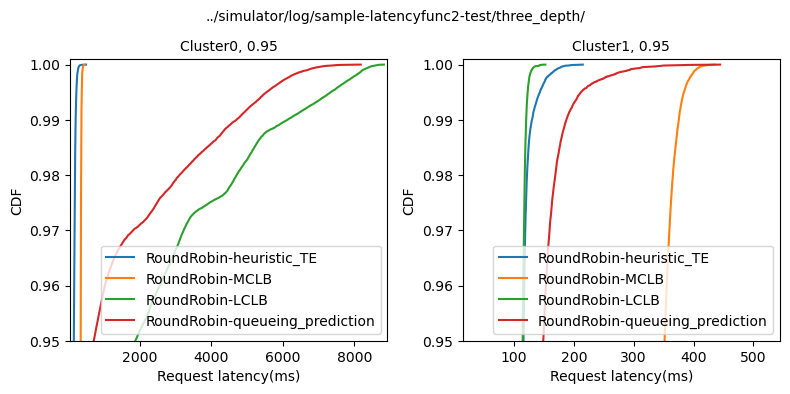

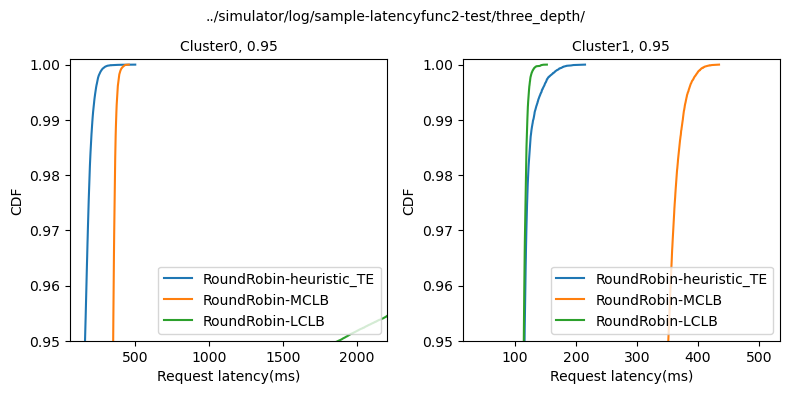

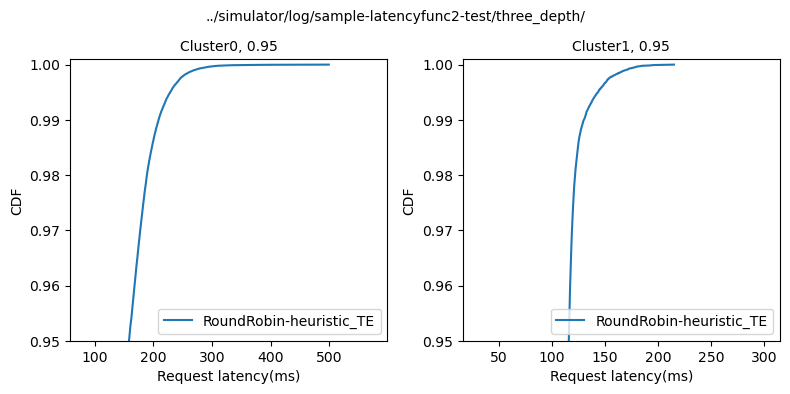

In [343]:
common_path="../simulator/log/sample-latencyfunc2-test/three_depth/"
# plot_latency(common_path, ["RoundRobin-LCLB", "RoundRobin-heuristic_TE", "RoundRobin-MCLB", "RoundRobin-capacity_TE", "RoundRobin-queueing_prediction"])
plot_latency(common_path, ["RoundRobin-heuristic_TE", "RoundRobin-MCLB", "RoundRobin-LCLB", "RoundRobin-queueing_prediction"])
plot_latency(common_path, ["RoundRobin-heuristic_TE", "RoundRobin-MCLB", "RoundRobin-LCLB"])
plot_latency(common_path, ["RoundRobin-heuristic_TE"])
# plot_latency(common_path)

RoundRobin-heuristic_TE agg max: 514.7675725738518
RoundRobin-heuristic_TE agg p99: 197.62581320060877
RoundRobin-heuristic_TE agg p999: 273.21745434169407
RoundRobin-MCLB agg max: 481.6509066376602
RoundRobin-MCLB agg p99: 370.03325346848453
RoundRobin-MCLB agg p999: 404.57693659912707
RoundRobin-LCLB agg max: 9459.266427403898
RoundRobin-LCLB agg p99: 6008.592869653634
RoundRobin-LCLB agg p999: 8926.658347488814
RoundRobin-heuristic_TE cluster 0 max: 514.7675725738518
RoundRobin-heuristic_TE cluster 0 max: 205.8071278882458
RoundRobin-heuristic_TE cluster 0 max: 283.9320746223425
RoundRobin-MCLB cluster 0 max: 476.6008573953877
RoundRobin-MCLB cluster 0 max: 367.3180748746299
RoundRobin-MCLB cluster 0 max: 402.1564514851889
RoundRobin-LCLB cluster 0 max: 9459.266427403898
RoundRobin-LCLB cluster 0 max: 6853.889910812337
RoundRobin-LCLB cluster 0 max: 8988.238763642466
RoundRobin-heuristic_TE cluster 1 max: 240.00577350961976
RoundRobin-heuristic_TE cluster 1 max: 127.00014113407583
R

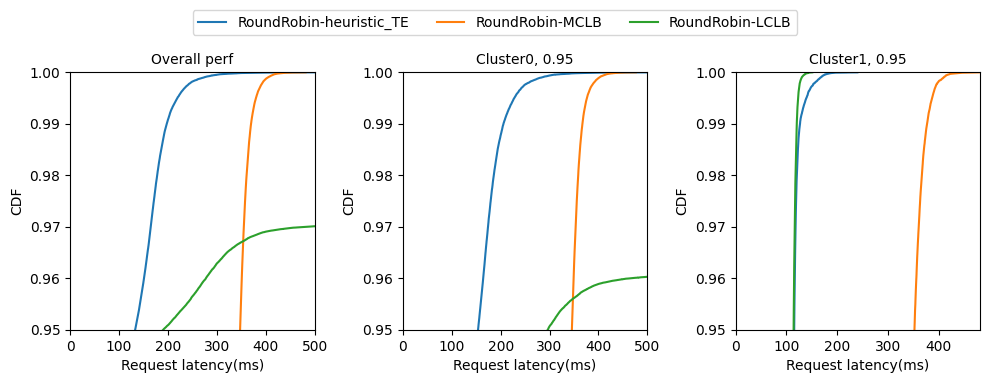

In [37]:
common_path="../simulator/log/smallsample/three_depth/"
plot_latency(common_path, ["RoundRobin-heuristic_TE", "RoundRobin-MCLB", "RoundRobin-LCLB"])
# plot_latency(common_path, ["RoundRobin-heuristic_TE", "RoundRobin-MCLB", "RoundRobin-moment_response_time"])
# plot_latency(common_path, ["LeastRequest-heuristic_TE", "LeastRequest-MCLB", "LeastRequest-LCLB"])

RoundRobin-heuristic_TE agg max: 754.1851926367963
RoundRobin-MCLB agg max: 482.41587740252726
RoundRobin-LCLB agg max: 7857.422564787441
RoundRobin-heuristic_TE cluster 0 max: 754.1851926367963
RoundRobin-MCLB cluster 0 max: 482.41587740252726
RoundRobin-LCLB cluster 0 max: 7857.422564787441
RoundRobin-heuristic_TE cluster 1 max: 255.37707489589772
RoundRobin-MCLB cluster 1 max: 461.7813354441896
RoundRobin-LCLB cluster 1 max: 170.63303190671934


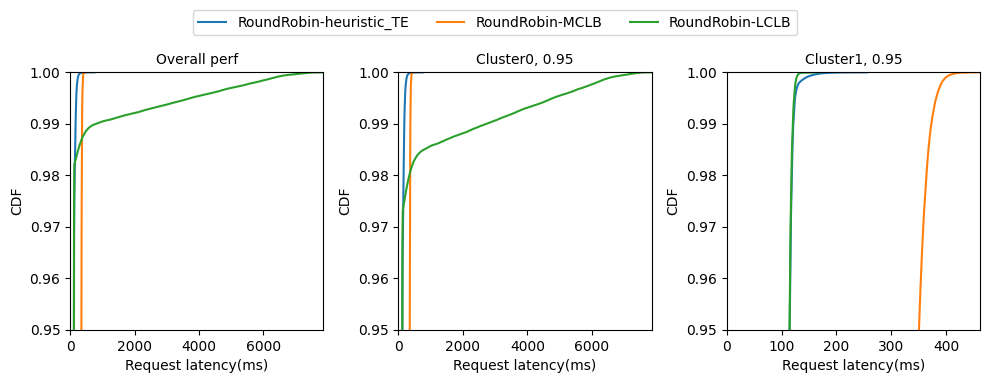

In [27]:
common_path="../simulator/log/halfsample/three_depth/"
plot_latency(common_path, ["RoundRobin-heuristic_TE", "RoundRobin-MCLB", "RoundRobin-LCLB"])
# 8s

RoundRobin-heuristic_TE agg max: 13180.35190732032
RoundRobin-heuristic_TE agg p99: 164.76818468496188
RoundRobin-heuristic_TE agg p999: 4234.283532260648
RoundRobin-MCLB agg max: 7572.489901438355
RoundRobin-MCLB agg p99: 374.97405586935577
RoundRobin-MCLB agg p999: 3714.956683369073
RoundRobin-LCLB agg max: 46071.09459213168
RoundRobin-LCLB agg p99: 1616.5317927718497
RoundRobin-LCLB agg p999: 26344.244578113787
RoundRobin-heuristic_TE cluster 0 max: 13180.35190732032
RoundRobin-heuristic_TE cluster 0 max: 190.44310714760377
RoundRobin-heuristic_TE cluster 0 max: 7376.064811512498
RoundRobin-MCLB cluster 0 max: 7572.489901438355
RoundRobin-MCLB cluster 0 max: 379.12340318229957
RoundRobin-MCLB cluster 0 max: 4775.884488640705
RoundRobin-LCLB cluster 0 max: 46071.09459213168
RoundRobin-LCLB cluster 0 max: 5001.462568322928
RoundRobin-LCLB cluster 0 max: 32975.057107409266
RoundRobin-heuristic_TE cluster 1 max: 2528.2749990969896
RoundRobin-heuristic_TE cluster 1 max: 120.8833391452953

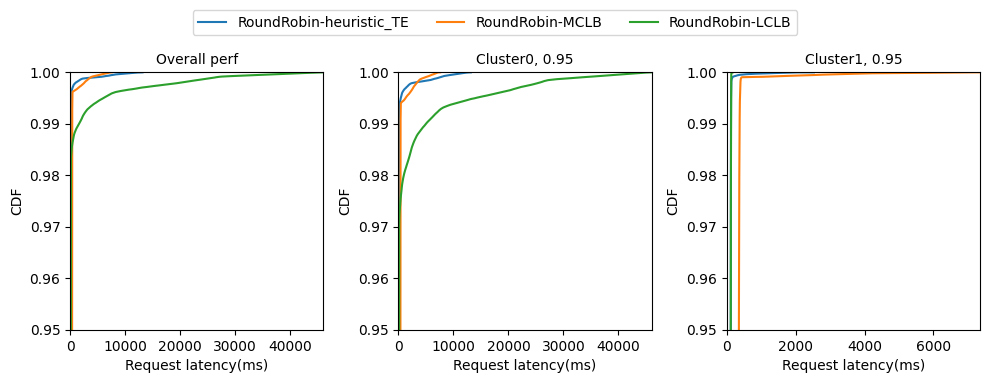

In [32]:
common_path="../simulator/log/fullsample/three_depth/"
plot_latency(common_path, ["RoundRobin-heuristic_TE", "RoundRobin-MCLB", "RoundRobin-LCLB"])
# 1m

RoundRobin-heuristic_TE agg max: 345.0311829149723
RoundRobin-heuristic_TE agg p99: 123.78655958684159
RoundRobin-heuristic_TE agg p999: 205.4684987650228
RoundRobin-MCLB agg max: 471.2871773290208
RoundRobin-MCLB agg p99: 364.1483074195683
RoundRobin-MCLB agg p999: 386.4587198019636
RoundRobin-LCLB agg max: 17898.00872927904
RoundRobin-LCLB agg p99: 121.89583595152247
RoundRobin-LCLB agg p999: 12409.505548542671
RoundRobin-heuristic_TE cluster 0 max: 345.0311829149723
RoundRobin-heuristic_TE cluster 0 max: 133.23212000131605
RoundRobin-heuristic_TE cluster 0 max: 218.80154738015221
RoundRobin-MCLB cluster 0 max: 471.2871773290208
RoundRobin-MCLB cluster 0 max: 362.1675240035355
RoundRobin-MCLB cluster 0 max: 384.1917378584902
RoundRobin-LCLB cluster 0 max: 17898.00872927904
RoundRobin-LCLB cluster 0 max: 124.23832423047861
RoundRobin-LCLB cluster 0 max: 14169.5517279537
RoundRobin-heuristic_TE cluster 1 max: 210.56202491843123
RoundRobin-heuristic_TE cluster 1 max: 120.33216580308975


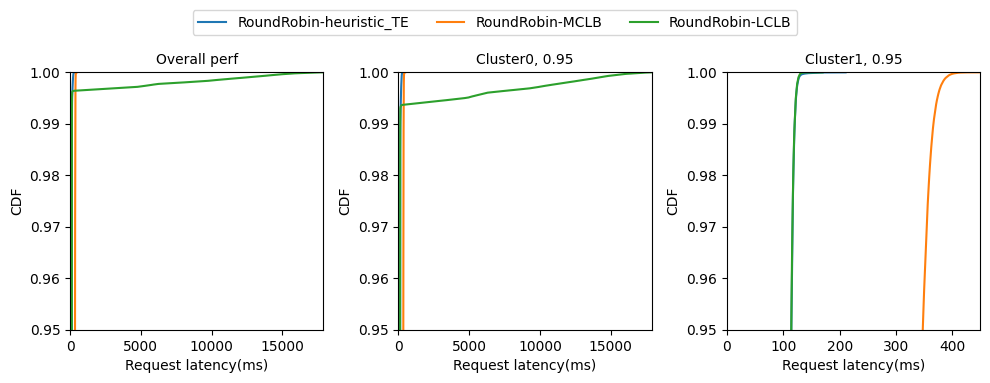

In [33]:
common_path="../simulator/log/fullsample/three_depth/"
plot_latency(common_path, ["RoundRobin-heuristic_TE", "RoundRobin-MCLB", "RoundRobin-LCLB"])
# 1m

RoundRobin-heuristic_TE agg max: 345.0311829149723
RoundRobin-heuristic_TE agg p99: 123.78655958684159
RoundRobin-heuristic_TE agg p999: 205.4684987650228
RoundRobin-MCLB agg max: 471.2871773290208
RoundRobin-MCLB agg p99: 364.1483074195683
RoundRobin-MCLB agg p999: 386.4587198019636
RoundRobin-LCLB agg max: 17898.00872927904
RoundRobin-LCLB agg p99: 121.89583595152247
RoundRobin-LCLB agg p999: 12409.505548542671
RoundRobin-heuristic_TE cluster 0 max: 345.0311829149723
RoundRobin-heuristic_TE cluster 0 max: 133.23212000131605
RoundRobin-heuristic_TE cluster 0 max: 218.80154738015221
RoundRobin-MCLB cluster 0 max: 471.2871773290208
RoundRobin-MCLB cluster 0 max: 362.1675240035355
RoundRobin-MCLB cluster 0 max: 384.1917378584902
RoundRobin-LCLB cluster 0 max: 17898.00872927904
RoundRobin-LCLB cluster 0 max: 124.23832423047861
RoundRobin-LCLB cluster 0 max: 14169.5517279537
RoundRobin-heuristic_TE cluster 1 max: 210.56202491843123
RoundRobin-heuristic_TE cluster 1 max: 120.33216580308975


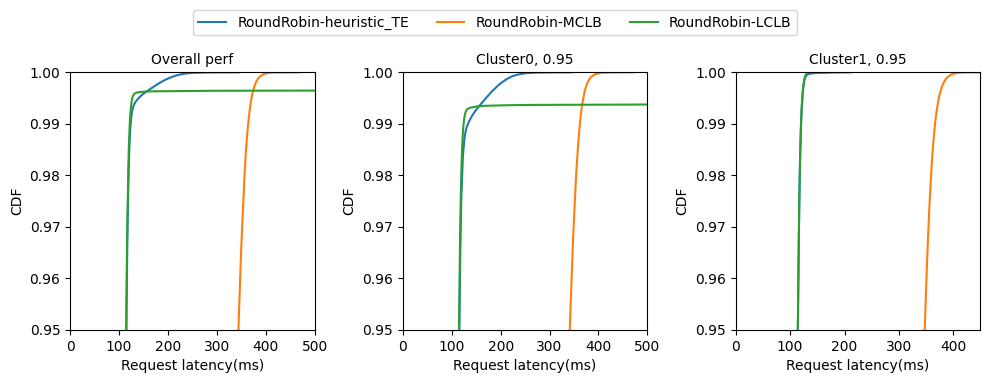

In [36]:
common_path="../simulator/log/fullsample/three_depth/"
plot_latency(common_path, ["RoundRobin-heuristic_TE", "RoundRobin-MCLB", "RoundRobin-LCLB"])
# 1m

106875ea
RoundRobin-heuristic_TE agg max: 256.15569999516083
RoundRobin-heuristic_TE agg p99: 121.88678073612977
RoundRobin-heuristic_TE agg p999: 137.77448597342158
RoundRobin-MCLB agg max: 455.3367377202958
RoundRobin-MCLB agg p99: 369.8423954514787
RoundRobin-MCLB agg p999: 394.717526534543
RoundRobin-LCLB agg max: 288.0903716161847
RoundRobin-LCLB agg p99: 121.1590238009393
RoundRobin-LCLB agg p999: 131.19801707727964
RoundRobin-heuristic_TE cluster 0 max: 245.62663409038944
RoundRobin-heuristic_TE cluster 0 max: 122.03369447400793
RoundRobin-heuristic_TE cluster 0 max: 138.82460063680318
RoundRobin-MCLB cluster 0 max: 451.4950755015016
RoundRobin-MCLB cluster 0 max: 369.5568345607072
RoundRobin-MCLB cluster 0 max: 394.471833455706
RoundRobin-LCLB cluster 0 max: 288.0903716161847
RoundRobin-LCLB cluster 0 max: 121.3064028647542
RoundRobin-LCLB cluster 0 max: 132.60987673455543
RoundRobin-heuristic_TE cluster 1 max: 256.15569999516083
RoundRobin-heuristic_TE cluster 1 max: 121.74398

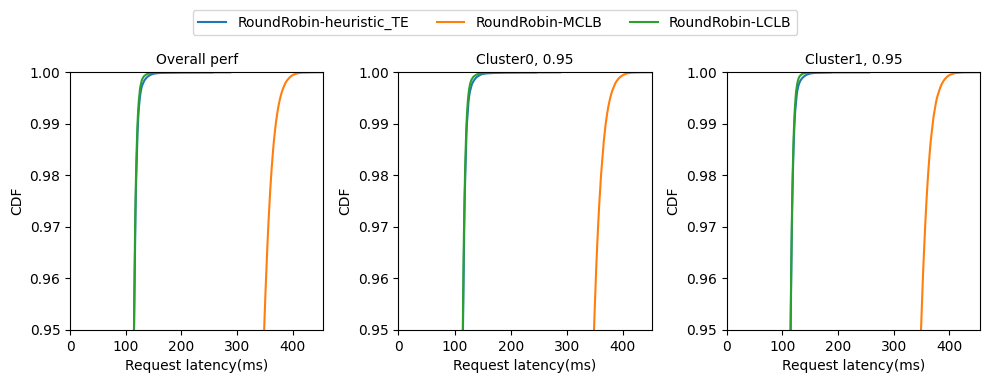

2516f878
RoundRobin-heuristic_TE agg max: 241.74930033832788
RoundRobin-heuristic_TE agg p99: 121.9742428289354
RoundRobin-heuristic_TE agg p999: 137.8801304655248
RoundRobin-MCLB agg max: 451.8241044282913
RoundRobin-MCLB agg p99: 369.107185054198
RoundRobin-MCLB agg p999: 394.1024079757208
RoundRobin-LCLB agg max: 189.6544345217881
RoundRobin-LCLB agg p99: 121.13856877267362
RoundRobin-LCLB agg p999: 130.83341866114756
RoundRobin-heuristic_TE cluster 0 max: 241.74930033832788
RoundRobin-heuristic_TE cluster 0 max: 122.0939633692801
RoundRobin-heuristic_TE cluster 0 max: 138.3010951568485
RoundRobin-MCLB cluster 0 max: 451.8241044282913
RoundRobin-MCLB cluster 0 max: 369.13376182296315
RoundRobin-MCLB cluster 0 max: 394.30336527563634
RoundRobin-LCLB cluster 0 max: 186.56165954470637
RoundRobin-LCLB cluster 0 max: 121.28697546581388
RoundRobin-LCLB cluster 0 max: 131.84675238627483
RoundRobin-heuristic_TE cluster 1 max: 234.484698966402
RoundRobin-heuristic_TE cluster 1 max: 121.85979

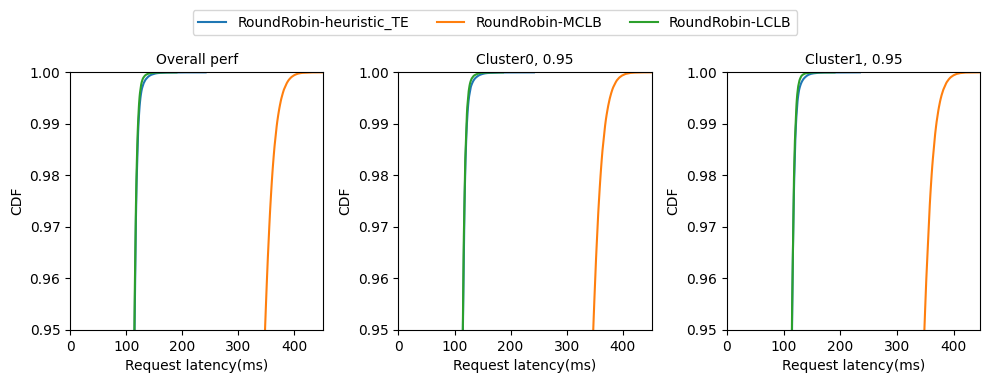

48f22403
RoundRobin-heuristic_TE agg max: 382.3580418676138
RoundRobin-heuristic_TE agg p99: 125.63957882829008
RoundRobin-heuristic_TE agg p999: 184.86739750276286
RoundRobin-MCLB agg max: 480.1069488030089
RoundRobin-MCLB agg p99: 370.2634977442024
RoundRobin-MCLB agg p999: 395.4612895046178
RoundRobin-LCLB agg max: 10636.58648429811
RoundRobin-LCLB agg p99: 125.47103017471717
RoundRobin-LCLB agg p999: 3569.9152329799194
RoundRobin-heuristic_TE cluster 0 max: 382.3580418676138
RoundRobin-heuristic_TE cluster 0 max: 133.40762897893785
RoundRobin-heuristic_TE cluster 0 max: 202.61003550900787
RoundRobin-MCLB cluster 0 max: 480.1069488030089
RoundRobin-MCLB cluster 0 max: 369.23789786931127
RoundRobin-MCLB cluster 0 max: 394.8210925540149
RoundRobin-LCLB cluster 0 max: 10636.58648429811
RoundRobin-LCLB cluster 0 max: 203.21255873772344
RoundRobin-LCLB cluster 0 max: 6227.254217831282
RoundRobin-heuristic_TE cluster 1 max: 229.1051131571603
RoundRobin-heuristic_TE cluster 1 max: 121.8697

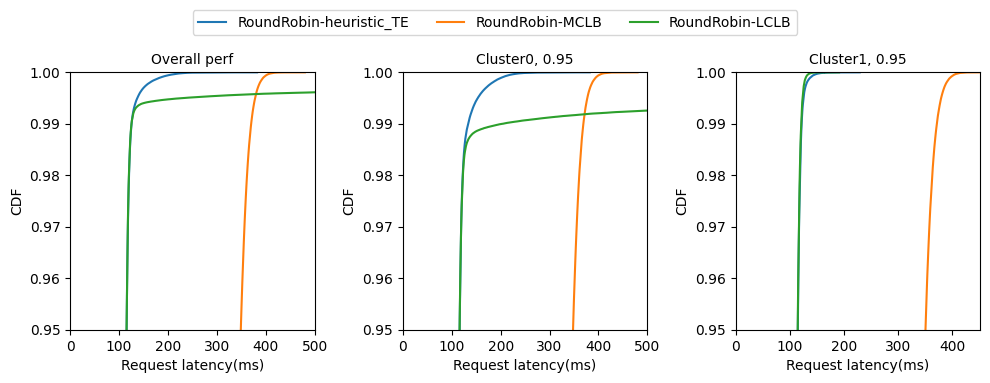

4a339ace
RoundRobin-heuristic_TE agg max: 276.9596437309356
RoundRobin-heuristic_TE agg p99: 122.17411470264197
RoundRobin-heuristic_TE agg p999: 141.55950468652514
RoundRobin-MCLB agg max: 453.1940564215183
RoundRobin-MCLB agg p99: 369.3755635941958
RoundRobin-MCLB agg p999: 394.06002360323305
RoundRobin-LCLB agg max: 422.4674892053008
RoundRobin-LCLB agg p99: 121.24818766996263
RoundRobin-LCLB agg p999: 132.92719965272036
RoundRobin-heuristic_TE cluster 0 max: 263.1612263917923
RoundRobin-heuristic_TE cluster 0 max: 122.6356924264878
RoundRobin-heuristic_TE cluster 0 max: 146.4986135768082
RoundRobin-MCLB cluster 0 max: 453.1940564215183
RoundRobin-MCLB cluster 0 max: 368.8452627611812
RoundRobin-MCLB cluster 0 max: 393.354224260302
RoundRobin-LCLB cluster 0 max: 422.4674892053008
RoundRobin-LCLB cluster 0 max: 121.5173336541932
RoundRobin-LCLB cluster 0 max: 137.9986502679083
RoundRobin-heuristic_TE cluster 1 max: 276.9596437309356
RoundRobin-heuristic_TE cluster 1 max: 121.73798547

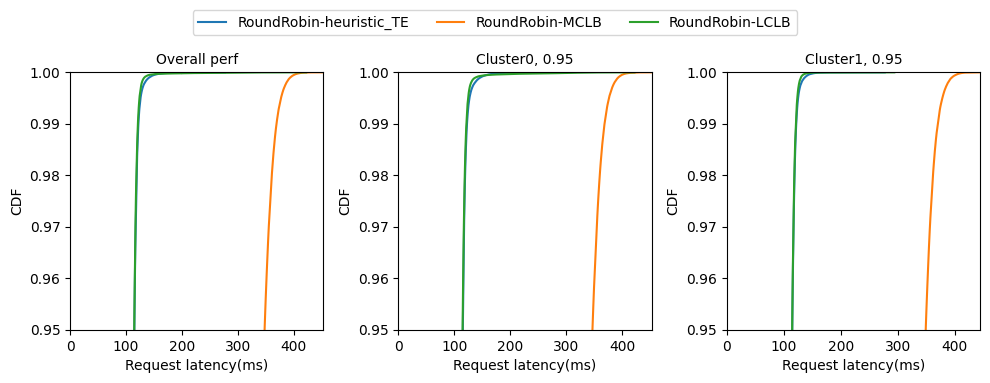

40734b8a
RoundRobin-heuristic_TE agg max: 591.9198456350714
RoundRobin-heuristic_TE agg p99: 148.7498250081763
RoundRobin-heuristic_TE agg p999: 225.41365719520027
RoundRobin-MCLB agg max: 773.5788644403219
RoundRobin-MCLB agg p99: 370.91482120027774
RoundRobin-MCLB agg p999: 403.01989578409456
RoundRobin-LCLB agg max: 25966.478748641908
RoundRobin-LCLB agg p99: 504.92006814778756
RoundRobin-LCLB agg p999: 7996.42932804542
RoundRobin-heuristic_TE cluster 0 max: 591.9198456350714
RoundRobin-heuristic_TE cluster 0 max: 169.43502657216052
RoundRobin-heuristic_TE cluster 0 max: 245.0190455617641
RoundRobin-MCLB cluster 0 max: 773.5788644403219
RoundRobin-MCLB cluster 0 max: 369.9150921528598
RoundRobin-MCLB cluster 0 max: 408.78818841596376
RoundRobin-LCLB cluster 0 max: 25966.478748641908
RoundRobin-LCLB cluster 0 max: 2828.073415884356
RoundRobin-LCLB cluster 0 max: 13499.872431361553
RoundRobin-heuristic_TE cluster 1 max: 433.6021423693746
RoundRobin-heuristic_TE cluster 1 max: 122.3283

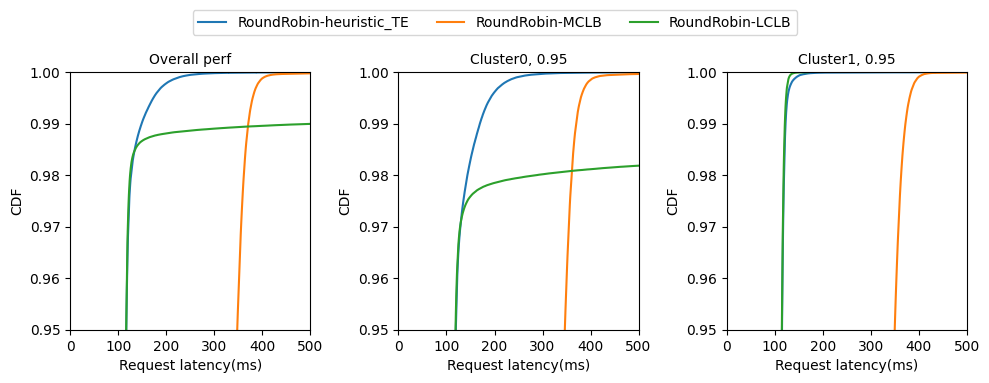

796af926
RoundRobin-heuristic_TE agg max: 228.4020827501317
RoundRobin-heuristic_TE agg p99: 122.00221330747935
RoundRobin-heuristic_TE agg p999: 138.45226602851156
RoundRobin-MCLB agg max: 458.1829857043922
RoundRobin-MCLB agg p99: 369.65094242453574
RoundRobin-MCLB agg p999: 394.18485220830524
RoundRobin-LCLB agg max: 524.9606484100223
RoundRobin-LCLB agg p99: 121.09828613325952
RoundRobin-LCLB agg p999: 130.78073895350255
RoundRobin-heuristic_TE cluster 0 max: 224.61361625045535
RoundRobin-heuristic_TE cluster 0 max: 122.26575968219903
RoundRobin-heuristic_TE cluster 0 max: 139.78983061163532
RoundRobin-MCLB cluster 0 max: 457.45021048747
RoundRobin-MCLB cluster 0 max: 369.65728497304013
RoundRobin-MCLB cluster 0 max: 394.3437966205587
RoundRobin-LCLB cluster 0 max: 524.9606484100223
RoundRobin-LCLB cluster 0 max: 121.34784899171444
RoundRobin-LCLB cluster 0 max: 131.99048432967078
RoundRobin-heuristic_TE cluster 1 max: 228.4020827501317
RoundRobin-heuristic_TE cluster 1 max: 121.73

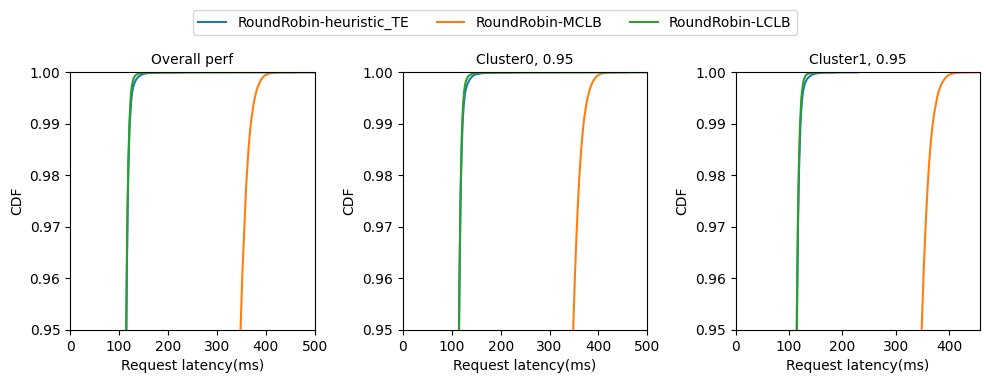

aba21e7a
RoundRobin-heuristic_TE agg max: 269.6324542775069
RoundRobin-heuristic_TE agg p99: 123.08704798426486
RoundRobin-heuristic_TE agg p999: 151.5316926756294
RoundRobin-MCLB agg max: 466.3814518004656
RoundRobin-MCLB agg p99: 369.3505517049598
RoundRobin-MCLB agg p999: 394.44617533804785
RoundRobin-LCLB agg max: 2223.8263384848838
RoundRobin-LCLB agg p99: 122.23889493368564
RoundRobin-LCLB agg p999: 162.4124157138837
RoundRobin-heuristic_TE cluster 0 max: 269.6324542775069
RoundRobin-heuristic_TE cluster 0 max: 124.61751600459216
RoundRobin-heuristic_TE cluster 0 max: 166.33190756118455
RoundRobin-MCLB cluster 0 max: 465.4086044877768
RoundRobin-MCLB cluster 0 max: 368.35442407466456
RoundRobin-MCLB cluster 0 max: 392.9905624220152
RoundRobin-LCLB cluster 0 max: 2223.8263384848838
RoundRobin-LCLB cluster 0 max: 123.92903865133874
RoundRobin-LCLB cluster 0 max: 268.2222069962679
RoundRobin-heuristic_TE cluster 1 max: 218.7018558718264
RoundRobin-heuristic_TE cluster 1 max: 121.897

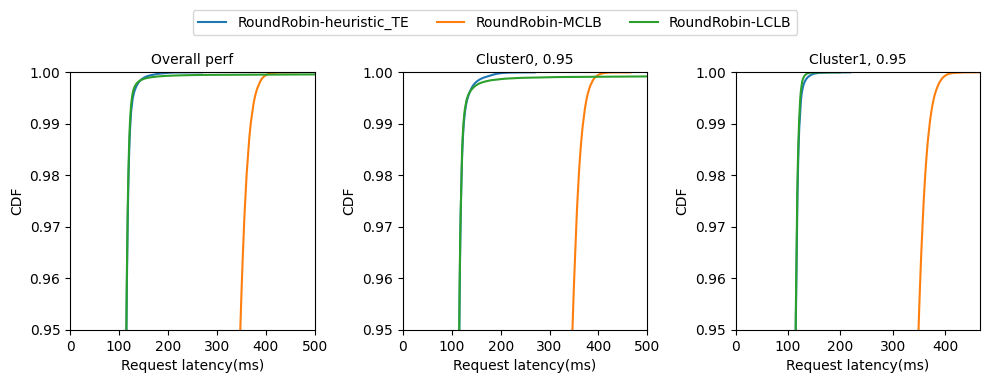

c636d684
RoundRobin-heuristic_TE agg max: 261.24781981489105
RoundRobin-heuristic_TE agg p99: 121.68482899513097
RoundRobin-heuristic_TE agg p999: 136.9458651514765
RoundRobin-MCLB agg max: 451.8338707536459
RoundRobin-MCLB agg p99: 369.3845244639367
RoundRobin-MCLB agg p999: 394.38900391030006
RoundRobin-LCLB agg max: 221.775944377202
RoundRobin-LCLB agg p99: 120.94243527182263
RoundRobin-LCLB agg p999: 129.76529408954482
RoundRobin-heuristic_TE cluster 0 max: 261.24781981489105
RoundRobin-heuristic_TE cluster 0 max: 121.63109940540045
RoundRobin-heuristic_TE cluster 0 max: 136.7946096915541
RoundRobin-MCLB cluster 0 max: 451.8338707536459
RoundRobin-MCLB cluster 0 max: 368.02675027202827
RoundRobin-MCLB cluster 0 max: 393.1575120516824
RoundRobin-LCLB cluster 0 max: 221.775944377202
RoundRobin-LCLB cluster 0 max: 120.88715011186898
RoundRobin-LCLB cluster 0 max: 129.47122970875486
RoundRobin-heuristic_TE cluster 1 max: 232.7119710782008
RoundRobin-heuristic_TE cluster 1 max: 121.7488

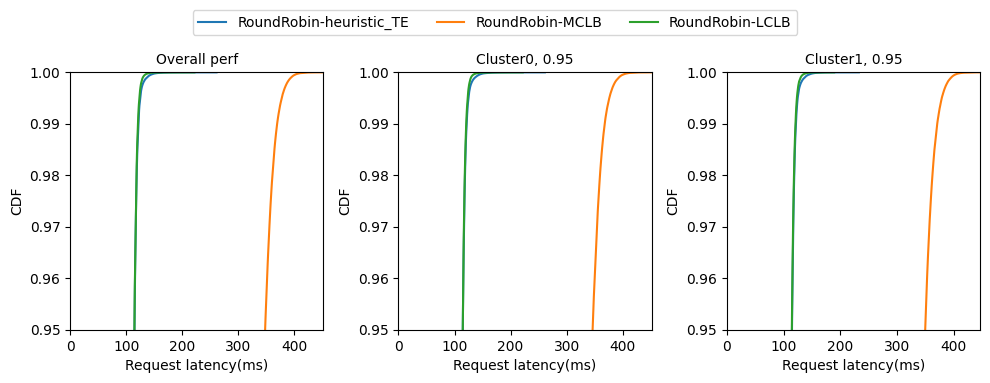

ccf3fa1f
RoundRobin-heuristic_TE agg max: 241.0470097601369
RoundRobin-heuristic_TE agg p99: 121.72658472575249
RoundRobin-heuristic_TE agg p999: 136.32184673037756
RoundRobin-MCLB agg max: 459.052566409111
RoundRobin-MCLB agg p99: 370.52898371119056
RoundRobin-MCLB agg p999: 394.9164931811495
RoundRobin-LCLB agg max: 180.7416760586202
RoundRobin-LCLB agg p99: 120.94656918719413
RoundRobin-LCLB agg p999: 129.75385261077818
RoundRobin-heuristic_TE cluster 0 max: 200.9228013213724
RoundRobin-heuristic_TE cluster 0 max: 121.72703016927466
RoundRobin-heuristic_TE cluster 0 max: 136.35795443749078
RoundRobin-MCLB cluster 0 max: 459.052566409111
RoundRobin-MCLB cluster 0 max: 370.4239256060123
RoundRobin-MCLB cluster 0 max: 395.0941054224982
RoundRobin-LCLB cluster 0 max: 166.93873790133148
RoundRobin-LCLB cluster 0 max: 120.9066673895717
RoundRobin-LCLB cluster 0 max: 129.7199277711979
RoundRobin-heuristic_TE cluster 1 max: 241.0470097601369
RoundRobin-heuristic_TE cluster 1 max: 121.724686

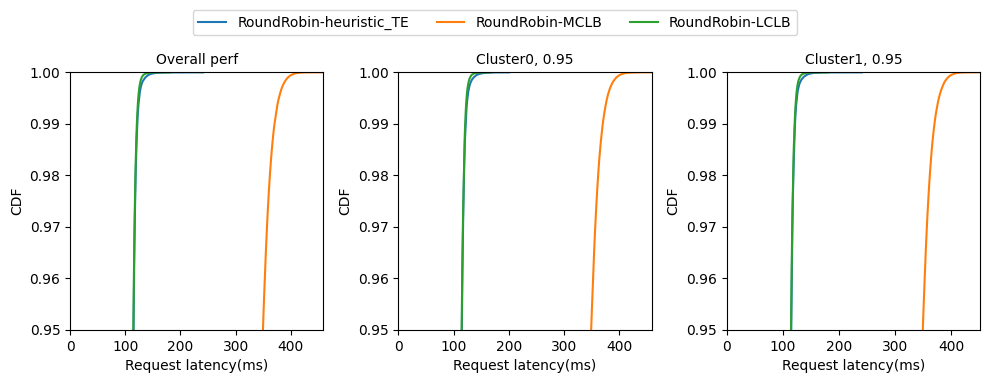

e2350413
RoundRobin-heuristic_TE agg max: 281.4728497696069
RoundRobin-heuristic_TE agg p99: 121.9006698267162
RoundRobin-heuristic_TE agg p999: 137.63985684316967
RoundRobin-MCLB agg max: 455.44624695251696
RoundRobin-MCLB agg p99: 370.3696411615796
RoundRobin-MCLB agg p999: 395.05170096524256
RoundRobin-LCLB agg max: 229.2877492010593
RoundRobin-LCLB agg p99: 121.1020443655551
RoundRobin-LCLB agg p999: 130.41691737827344
RoundRobin-heuristic_TE cluster 0 max: 281.4728497696069
RoundRobin-heuristic_TE cluster 0 max: 121.97727535739538
RoundRobin-heuristic_TE cluster 0 max: 138.1487518332039
RoundRobin-MCLB cluster 0 max: 455.44624695251696
RoundRobin-MCLB cluster 0 max: 370.23284718353756
RoundRobin-MCLB cluster 0 max: 394.7911894724616
RoundRobin-LCLB cluster 0 max: 185.8998305127025
RoundRobin-LCLB cluster 0 max: 121.15500351324678
RoundRobin-LCLB cluster 0 max: 130.6789315471502
RoundRobin-heuristic_TE cluster 1 max: 222.92265205830336
RoundRobin-heuristic_TE cluster 1 max: 121.828

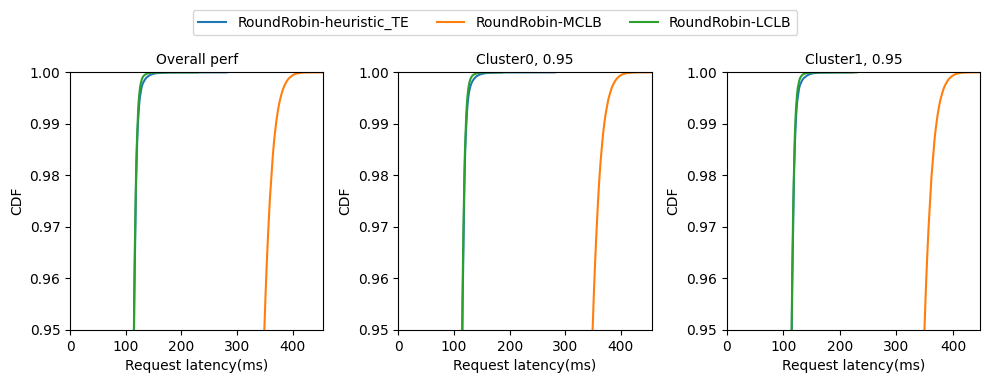

In [5]:
wrk_10 = ["106875ea" \
,"2516f878" \
,"48f22403" \
,"4a339ace" \
,"40734b8a" \
,"796af926" \
,"aba21e7a" \
,"c636d684" \
,"ccf3fa1f" \
,"e2350413"]
for wrk in wrk_10:
    print(wrk)
    common_path="/home/gangmuk2/projects/slate-sim/simulator/request_arrival/11_wrk/log/"+wrk+"/three_depth/"
    plot_latency(common_path, ["RoundRobin-heuristic_TE", "RoundRobin-MCLB", "RoundRobin-LCLB"])

106875ea
RoundRobin-heuristic_TE agg max: 357.82019617408514
RoundRobin-heuristic_TE agg p99: 138.79829083755604
RoundRobin-heuristic_TE agg p999: 183.0388314054914
RoundRobin-MCLB agg max: 470.383530203253
RoundRobin-MCLB agg p99: 374.5960424139722
RoundRobin-MCLB agg p999: 399.73215258327156
RoundRobin-LCLB agg max: 373.5013163611293
RoundRobin-LCLB agg p99: 134.09721923613918
RoundRobin-LCLB agg p999: 162.86995245352415
RoundRobin-heuristic_TE cluster 0 max: 270.48562287539244
RoundRobin-heuristic_TE cluster 0 max: 140.27417981375
RoundRobin-heuristic_TE cluster 0 max: 189.30132541839794
RoundRobin-MCLB cluster 0 max: 467.9566814675927
RoundRobin-MCLB cluster 0 max: 374.8011436791346
RoundRobin-MCLB cluster 0 max: 399.6202760808478
RoundRobin-LCLB cluster 0 max: 373.5013163611293
RoundRobin-LCLB cluster 0 max: 135.76875142738228
RoundRobin-LCLB cluster 0 max: 169.0741554928798
RoundRobin-heuristic_TE cluster 1 max: 357.82019617408514
RoundRobin-heuristic_TE cluster 1 max: 137.278897

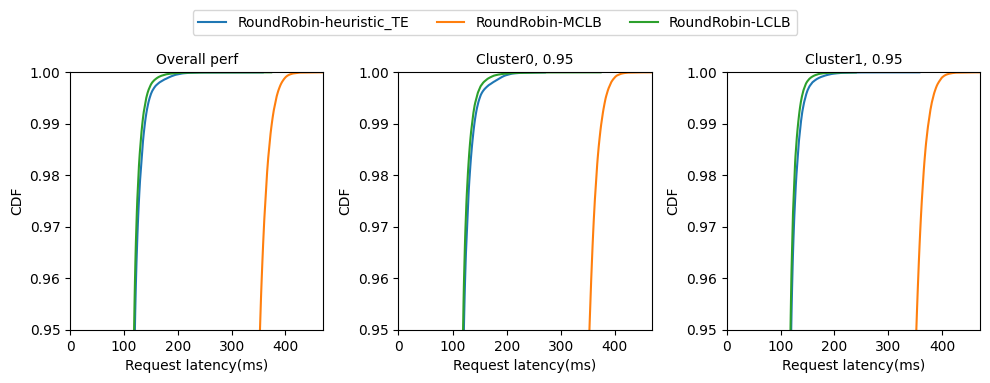

2516f878
RoundRobin-heuristic_TE agg max: 330.34819881245494
RoundRobin-heuristic_TE agg p99: 139.91318833746024
RoundRobin-heuristic_TE agg p999: 180.72218164652975
RoundRobin-MCLB agg max: 483.6337464824319
RoundRobin-MCLB agg p99: 375.2458216401934
RoundRobin-MCLB agg p999: 400.58200507998487
RoundRobin-LCLB agg max: 405.86698004230857
RoundRobin-LCLB agg p99: 134.1401680523902
RoundRobin-LCLB agg p999: 159.89930083516612
RoundRobin-heuristic_TE cluster 0 max: 289.7493743225932
RoundRobin-heuristic_TE cluster 0 max: 142.39296427226915
RoundRobin-heuristic_TE cluster 0 max: 185.01257999841718
RoundRobin-MCLB cluster 0 max: 474.0025686994195
RoundRobin-MCLB cluster 0 max: 375.9532319724559
RoundRobin-MCLB cluster 0 max: 401.18261291804055
RoundRobin-LCLB cluster 0 max: 405.86698004230857
RoundRobin-LCLB cluster 0 max: 135.51769895136357
RoundRobin-LCLB cluster 0 max: 163.21081100712976
RoundRobin-heuristic_TE cluster 1 max: 330.34819881245494
RoundRobin-heuristic_TE cluster 1 max: 137

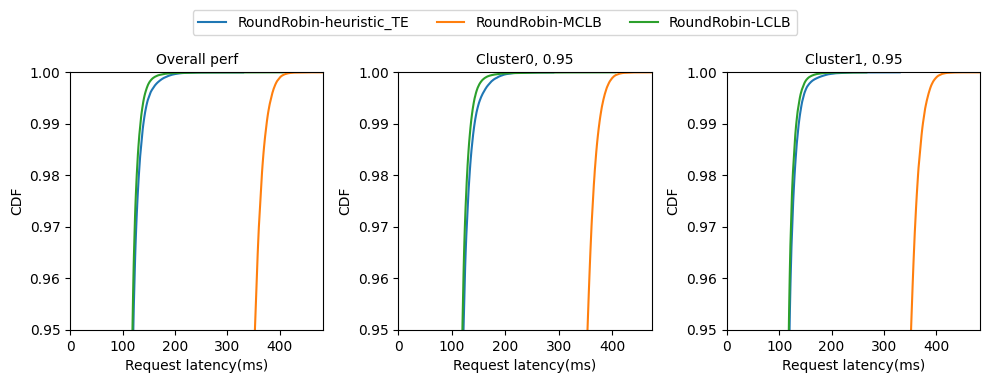

48f22403
RoundRobin-heuristic_TE agg max: 3561.9078632965684
RoundRobin-heuristic_TE agg p99: 153.47104039300237
RoundRobin-heuristic_TE agg p999: 298.3848471877734
RoundRobin-MCLB agg max: 1359.2620300492272
RoundRobin-MCLB agg p99: 377.0018857876394
RoundRobin-MCLB agg p999: 509.4116541929821
RoundRobin-LCLB agg max: 20649.75662046671
RoundRobin-LCLB agg p99: 425.6499239729897
RoundRobin-LCLB agg p999: 9905.447169467272
RoundRobin-heuristic_TE cluster 0 max: 3561.9078632965684
RoundRobin-heuristic_TE cluster 0 max: 176.2121841451522
RoundRobin-heuristic_TE cluster 0 max: 733.1702528972453
RoundRobin-MCLB cluster 0 max: 1359.2620300492272
RoundRobin-MCLB cluster 0 max: 378.0808847849816
RoundRobin-MCLB cluster 0 max: 632.1731264405757
RoundRobin-LCLB cluster 0 max: 20649.75662046671
RoundRobin-LCLB cluster 0 max: 3899.31292453512
RoundRobin-LCLB cluster 0 max: 13145.75319198092
RoundRobin-heuristic_TE cluster 1 max: 558.1834276989102
RoundRobin-heuristic_TE cluster 1 max: 139.58142549

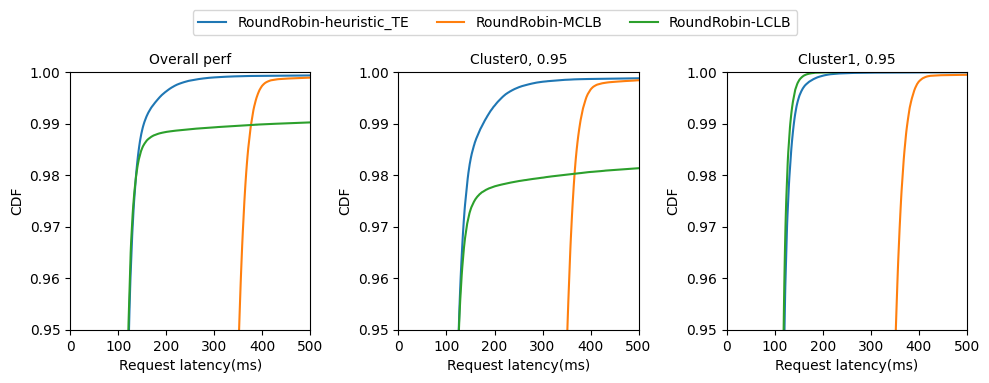

4a339ace
RoundRobin-heuristic_TE agg max: 369.6842015311122
RoundRobin-heuristic_TE agg p99: 139.96990321364262
RoundRobin-heuristic_TE agg p999: 187.3731004583602
RoundRobin-MCLB agg max: 514.7317593842745
RoundRobin-MCLB agg p99: 371.64820489466183
RoundRobin-MCLB agg p999: 397.7583357749365
RoundRobin-LCLB agg max: 6229.683306023479
RoundRobin-LCLB agg p99: 135.83936626892523
RoundRobin-LCLB agg p999: 832.1641588627642
RoundRobin-heuristic_TE cluster 0 max: 369.6842015311122
RoundRobin-heuristic_TE cluster 0 max: 142.7632792449556
RoundRobin-heuristic_TE cluster 0 max: 196.38874067122174
RoundRobin-MCLB cluster 0 max: 514.7317593842745
RoundRobin-MCLB cluster 0 max: 371.74889158795577
RoundRobin-MCLB cluster 0 max: 398.05725805673364
RoundRobin-LCLB cluster 0 max: 6229.683306023479
RoundRobin-LCLB cluster 0 max: 139.75311046849924
RoundRobin-LCLB cluster 0 max: 3331.9684754930904
RoundRobin-heuristic_TE cluster 1 max: 297.18618169799447
RoundRobin-heuristic_TE cluster 1 max: 137.297

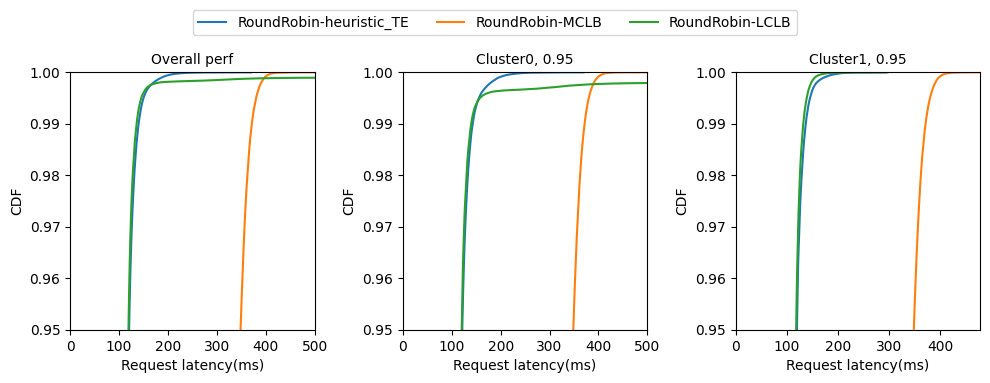

40734b8a
RoundRobin-heuristic_TE agg max: 9793.320280674843
RoundRobin-heuristic_TE agg p99: 236.80597683433214
RoundRobin-heuristic_TE agg p999: 5095.545006437071
RoundRobin-MCLB agg max: 8288.52902745828
RoundRobin-MCLB agg p99: 414.4070719331503
RoundRobin-MCLB agg p999: 5814.1666775590775
RoundRobin-LCLB agg max: 30570.144330127165
RoundRobin-LCLB agg p99: 6113.164172656381
RoundRobin-LCLB agg p999: 18462.938715984936
RoundRobin-heuristic_TE cluster 0 max: 9793.320280674843
RoundRobin-heuristic_TE cluster 0 max: 498.9042711697421
RoundRobin-heuristic_TE cluster 0 max: 6332.452368632582
RoundRobin-MCLB cluster 0 max: 8262.608348522335
RoundRobin-MCLB cluster 0 max: 1278.576812061126
RoundRobin-MCLB cluster 0 max: 6324.8116878815845
RoundRobin-LCLB cluster 0 max: 30570.144330127165
RoundRobin-LCLB cluster 0 max: 9165.927062496987
RoundRobin-LCLB cluster 0 max: 20488.529336608848
RoundRobin-heuristic_TE cluster 1 max: 6862.811576262582
RoundRobin-heuristic_TE cluster 1 max: 144.391672

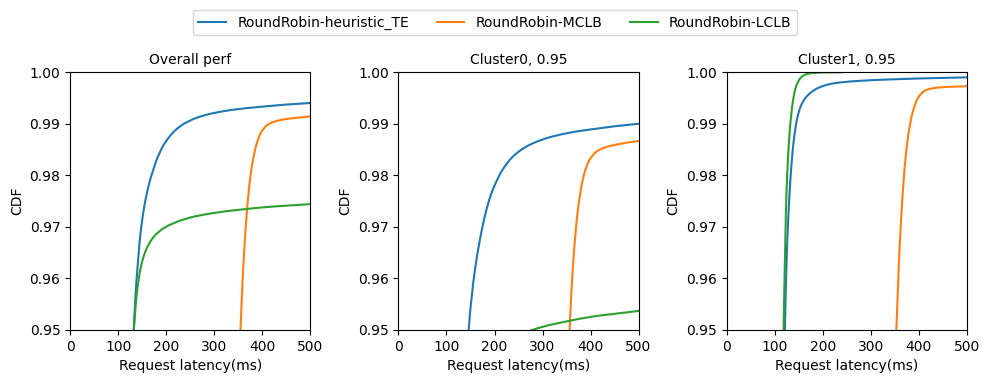

796af926
RoundRobin-heuristic_TE agg max: 333.8033764511347
RoundRobin-heuristic_TE agg p99: 140.46461169920863
RoundRobin-heuristic_TE agg p999: 183.52877680881426
RoundRobin-MCLB agg max: 465.06519295228645
RoundRobin-MCLB agg p99: 373.3267622075974
RoundRobin-MCLB agg p999: 399.022452974009
RoundRobin-LCLB agg max: 781.5470557063818
RoundRobin-LCLB agg p99: 134.37438393235203
RoundRobin-LCLB agg p999: 168.38021234509014
RoundRobin-heuristic_TE cluster 0 max: 333.8033764511347
RoundRobin-heuristic_TE cluster 0 max: 143.9967442436516
RoundRobin-heuristic_TE cluster 0 max: 189.178088288666
RoundRobin-MCLB cluster 0 max: 461.81715511903167
RoundRobin-MCLB cluster 0 max: 373.8188897952809
RoundRobin-MCLB cluster 0 max: 399.4076825646961
RoundRobin-LCLB cluster 0 max: 781.5470557063818
RoundRobin-LCLB cluster 0 max: 136.87957845510914
RoundRobin-LCLB cluster 0 max: 187.54671036267504
RoundRobin-heuristic_TE cluster 1 max: 270.6199636608362
RoundRobin-heuristic_TE cluster 1 max: 137.218004

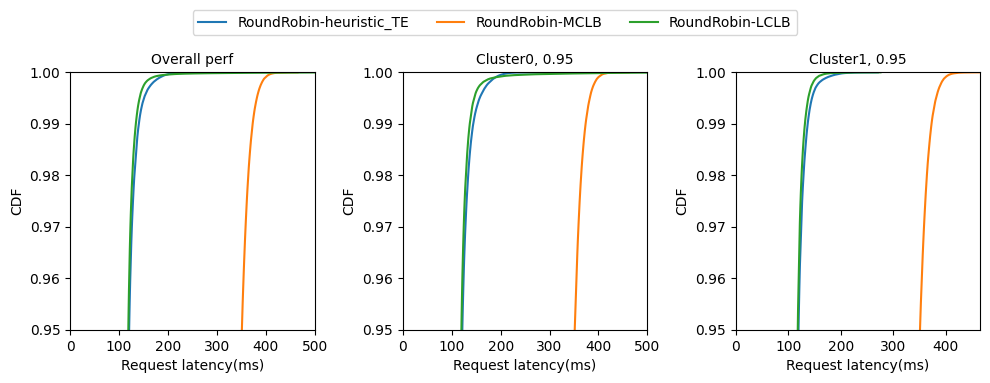

aba21e7a
RoundRobin-heuristic_TE agg max: 544.3739747293293
RoundRobin-heuristic_TE agg p99: 143.0429295851104
RoundRobin-heuristic_TE agg p999: 215.57239513101908
RoundRobin-MCLB agg max: 493.4395535625517
RoundRobin-MCLB agg p99: 375.3523092696723
RoundRobin-MCLB agg p999: 401.9426636445325
RoundRobin-LCLB agg max: 10194.97978501022
RoundRobin-LCLB agg p99: 139.4237249293178
RoundRobin-LCLB agg p999: 3297.5124936110174
RoundRobin-heuristic_TE cluster 0 max: 544.3739747293293
RoundRobin-heuristic_TE cluster 0 max: 148.80353563804155
RoundRobin-heuristic_TE cluster 0 max: 256.46518785446284
RoundRobin-MCLB cluster 0 max: 493.4395535625517
RoundRobin-MCLB cluster 0 max: 375.1390369905904
RoundRobin-MCLB cluster 0 max: 401.634477397167
RoundRobin-LCLB cluster 0 max: 10194.97978501022
RoundRobin-LCLB cluster 0 max: 152.37878915684269
RoundRobin-LCLB cluster 0 max: 5412.230022372611
RoundRobin-heuristic_TE cluster 1 max: 514.7741777263582
RoundRobin-heuristic_TE cluster 1 max: 137.91044521

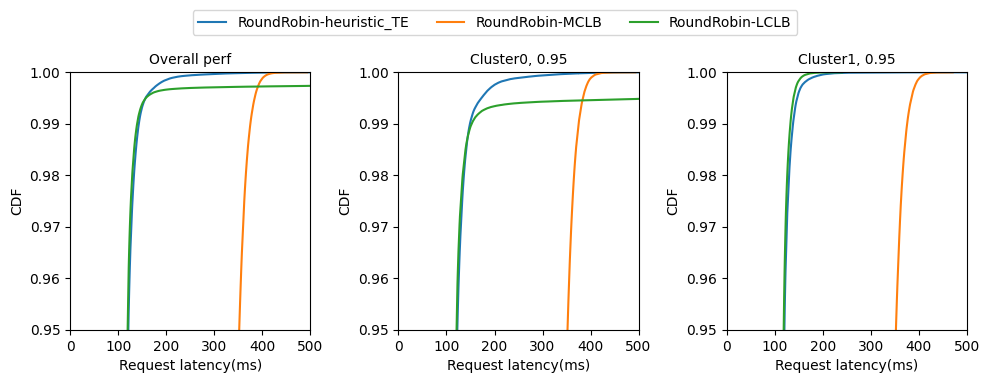

c636d684
RoundRobin-heuristic_TE agg max: 353.8394097834825
RoundRobin-heuristic_TE agg p99: 138.25128904942423
RoundRobin-heuristic_TE agg p999: 179.5043198511753
RoundRobin-MCLB agg max: 475.9582509249449
RoundRobin-MCLB agg p99: 374.19422219391913
RoundRobin-MCLB agg p999: 399.81635254862255
RoundRobin-LCLB agg max: 544.7061352953315
RoundRobin-LCLB agg p99: 133.2422986120637
RoundRobin-LCLB agg p999: 172.62303847281527
RoundRobin-heuristic_TE cluster 0 max: 353.8394097834825
RoundRobin-heuristic_TE cluster 0 max: 139.01320057235657
RoundRobin-heuristic_TE cluster 0 max: 182.89822821238894
RoundRobin-MCLB cluster 0 max: 464.2959374470811
RoundRobin-MCLB cluster 0 max: 373.6945705817642
RoundRobin-MCLB cluster 0 max: 399.41089934609147
RoundRobin-LCLB cluster 0 max: 544.7061352953315
RoundRobin-LCLB cluster 0 max: 133.95980728939188
RoundRobin-LCLB cluster 0 max: 206.15509036511384
RoundRobin-heuristic_TE cluster 1 max: 338.82897572929505
RoundRobin-heuristic_TE cluster 1 max: 137.44

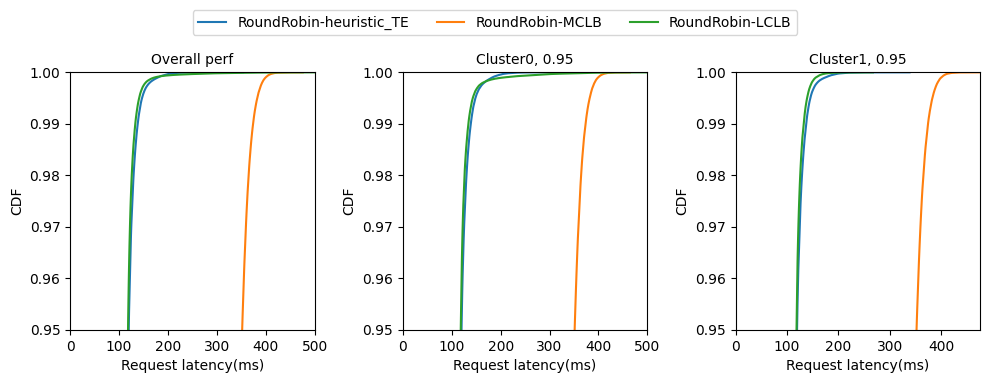

ccf3fa1f
RoundRobin-heuristic_TE agg max: 284.02916503697634
RoundRobin-heuristic_TE agg p99: 137.10249928861856
RoundRobin-heuristic_TE agg p999: 172.8808423522119
RoundRobin-MCLB agg max: 475.2831467000651
RoundRobin-MCLB agg p99: 371.72510474445284
RoundRobin-MCLB agg p999: 396.9655536983498
RoundRobin-LCLB agg max: 271.8453129277332
RoundRobin-LCLB agg p99: 132.08214032258826
RoundRobin-LCLB agg p999: 154.48570850785106
RoundRobin-heuristic_TE cluster 0 max: 284.02916503697634
RoundRobin-heuristic_TE cluster 0 max: 137.11741851434113
RoundRobin-heuristic_TE cluster 0 max: 171.70918903420633
RoundRobin-MCLB cluster 0 max: 475.2831467000651
RoundRobin-MCLB cluster 0 max: 371.81101254317895
RoundRobin-MCLB cluster 0 max: 396.9260830763728
RoundRobin-LCLB cluster 0 max: 265.88764545787126
RoundRobin-LCLB cluster 0 max: 132.02899895235893
RoundRobin-LCLB cluster 0 max: 154.42432922925067
RoundRobin-heuristic_TE cluster 1 max: 274.0379632599652
RoundRobin-heuristic_TE cluster 1 max: 137.

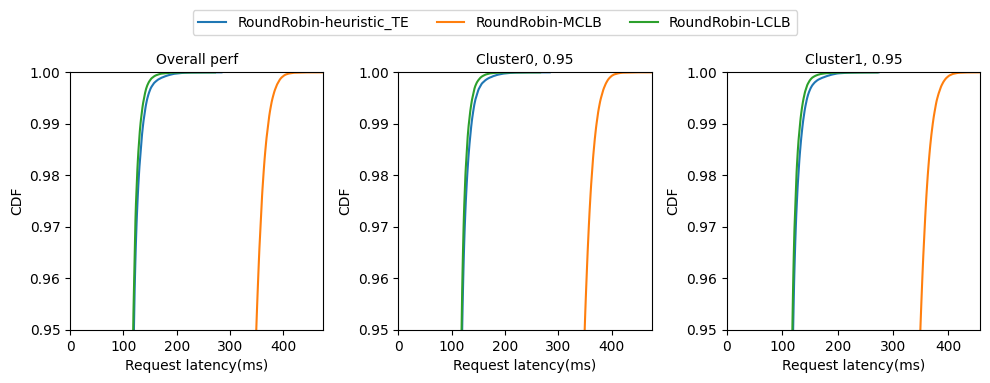

e2350413
RoundRobin-heuristic_TE agg max: 292.40949799725786
RoundRobin-heuristic_TE agg p99: 139.14290745615955
RoundRobin-heuristic_TE agg p999: 180.0940175080406
RoundRobin-MCLB agg max: 469.3113632760942
RoundRobin-MCLB agg p99: 373.38859419595434
RoundRobin-MCLB agg p999: 398.87360638911287
RoundRobin-LCLB agg max: 267.35374539345503
RoundRobin-LCLB agg p99: 134.21969791304318
RoundRobin-LCLB agg p999: 160.0902352024998
RoundRobin-heuristic_TE cluster 0 max: 281.4728497696069
RoundRobin-heuristic_TE cluster 0 max: 140.59155267063537
RoundRobin-heuristic_TE cluster 0 max: 184.72370897019846
RoundRobin-MCLB cluster 0 max: 469.3113632760942
RoundRobin-MCLB cluster 0 max: 373.63792384557416
RoundRobin-MCLB cluster 0 max: 399.1477788781231
RoundRobin-LCLB cluster 0 max: 267.35374539345503
RoundRobin-LCLB cluster 0 max: 135.4034591808174
RoundRobin-LCLB cluster 0 max: 162.5942508770215
RoundRobin-heuristic_TE cluster 1 max: 292.40949799725786
RoundRobin-heuristic_TE cluster 1 max: 137.7

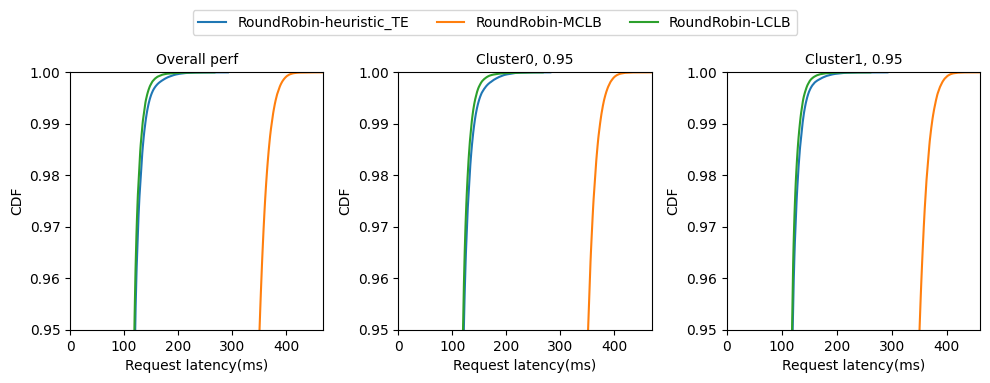

In [6]:
wrk_10 = ["106875ea" \
,"2516f878" \
,"48f22403" \
,"4a339ace" \
,"40734b8a" \
,"796af926" \
,"aba21e7a" \
,"c636d684" \
,"ccf3fa1f" \
,"e2350413"]
for wrk in wrk_10:
    print(wrk)
    common_path="/home/gangmuk2/projects/slate-sim/simulator/request_arrival/11_wrk/log/autoscaler40/"+wrk+"/three_depth/"
    plot_latency(common_path, ["RoundRobin-heuristic_TE", "RoundRobin-MCLB", "RoundRobin-LCLB"])

EWMA_ResponseTime-heuristic_TE agg max: 405.2231083586812
EWMA_ResponseTime-heuristic_TE agg p99: 164.7544538518414
EWMA_ResponseTime-heuristic_TE agg p999: 197.7649378426376
EWMA_ResponseTime-MCLB agg max: 2350.372988052666
EWMA_ResponseTime-MCLB agg p99: 291.10533518716693
EWMA_ResponseTime-MCLB agg p999: 584.884685038999
EWMA_ResponseTime-LCLB agg max: 11582.791020952163
EWMA_ResponseTime-LCLB agg p99: 255.83845928877068
EWMA_ResponseTime-LCLB agg p999: 3474.4451274933695
RoundRobin-heuristic_TE agg max: 382.3580418676138
RoundRobin-heuristic_TE agg p99: 125.63957882829008
RoundRobin-heuristic_TE agg p999: 184.86739750276286
RoundRobin-MCLB agg max: 480.1069488030089
RoundRobin-MCLB agg p99: 370.2634977442024
RoundRobin-MCLB agg p999: 395.4612895046178
RoundRobin-LCLB agg max: 10636.58648429811
RoundRobin-LCLB agg p99: 125.47103017471717
RoundRobin-LCLB agg p999: 3569.9152329799194
EWMA_ResponseTime-heuristic_TE cluster 0 max: 405.2231083586812
EWMA_ResponseTime-heuristic_TE cluster

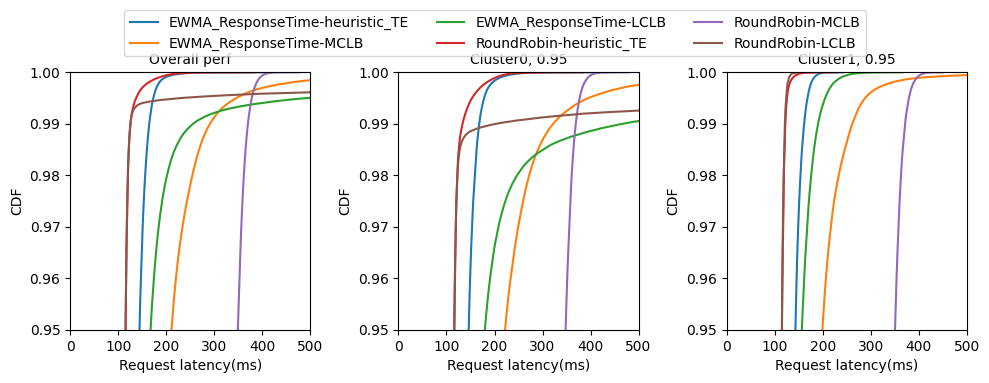

In [7]:
common_path="/home/gangmuk2/projects/slate-sim/simulator/request_arrival/11_wrk/log/autoscaler25/48f22403/three_depth/"
plot_latency(common_path, ["EWMA_ResponseTime-heuristic_TE", "EWMA_ResponseTime-MCLB", "EWMA_ResponseTime-LCLB", "RoundRobin-heuristic_TE", "RoundRobin-MCLB", "RoundRobin-LCLB"])

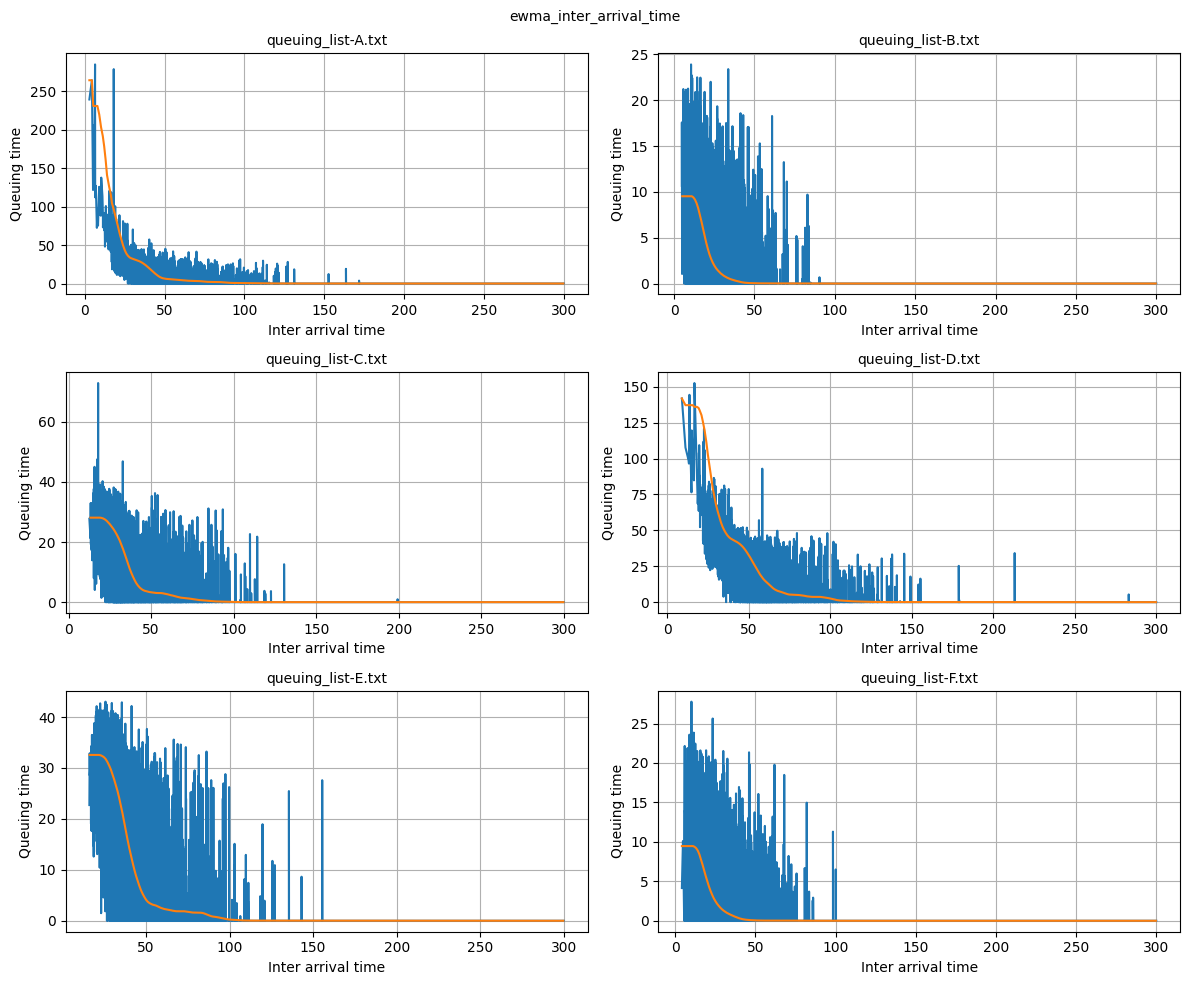

In [87]:
routing = "RoundRobin-heuristic_TE"
# routing = "RoundRobin-queueing_prediction"
common_path="../simulator/log/sample-latencyfunc2-test/three_depth/"
svc_list = ["A","B","C","D","E","F"]
inter_arrival_time_col =["moving_avg_inter_arrival_time_5"
                        ,"moving_avg_inter_arrival_time_10"
                        ,"moving_avg_inter_arrival_time_12"
                        ,"moving_avg_inter_arrival_time_15"
                        ,"moving_avg_inter_arrival_time_20"
                        ,"ewma_inter_arrival_time"]
inter_arrival_time_col =["ewma_inter_arrival_time"]

def latency_function_df(path_, target_inter_arr_time):
    df = pd.read_csv(path_)
    df["inverse_of_inter_arrival_time"] = 1/df[target_inter_arr_time]
    max_inter_arrival_time = 300
    num_drop = len(df[df[target_inter_arr_time] >= max_inter_arrival_time])
    df = df[df[target_inter_arr_time] < max_inter_arrival_time]
    df = df.sort_values(by=target_inter_arr_time)
    round_degree = 0
    df["rounded_inter_arrival_time"] = round(df[target_inter_arr_time], round_degree)
    # groupby_df = df.groupby('rounded_inter_arrival_time').max()
    # groupby_df = df.groupby('rounded_inter_arrival_time').min()
    groupby_df = df.groupby('rounded_inter_arrival_time').mean()
    groupby_df.reset_index(inplace=True)
    for i in range(len(groupby_df)):
        groupby_df.loc[i]
    df = df.reset_index(drop=False)
    # display(df)
    # display(groupby_df)
    return df, groupby_df


def ewma(curr, prev, lmda=0.632):
    # EWMA_t = λY_t+(1−λ)EWMA_t−1
    if prev == 0:
        return curr
    return lmda*curr + (1-lmda)*prev


# ## Original data point
# fig = plt.figure(figsize=(12, 10))
# fig.suptitle(common_path, fontsize=10)
# subplot_pos = 1
# for svc in svc_list:
#     pa_ = common_path + routing + "/queuing_list-"+svc+".txt"
#     df, groupby_df = latency_function_df(pa_)
#     ax1 = fig.add_subplot(3, 2, subplot_pos) # (row, col, the position of the current plot)
#     plt.plot(df[inter_arrival_time_col], df["queuing_time"])
#     ax1.set_xlabel("Inter Arrival Time (ewma)")#, fontsize=10)
#     ax1.set_ylabel("Queuing Time (Original)")#, fontsize=10)
#     ax1.set_title(pa_.split("/")[-1], fontsize=10)
#     subplot_pos += 1
# fig.tight_layout()
# plt.show()


# ## Moving average -> Round up by 0 degree ->  Mean Group by inter arrival time
# window_size = 5
# fig = plt.figure(figsize=(12, 10))
# fig.suptitle(common_path, fontsize=10)
# subplot_pos = 1
# for svc in svc_list:
#     pa_ = common_path + routing + "/queuing_list-"+svc+".txt"
#     df, groupby_df = latency_function_df(pa_)
#     moving_avg_of_queuing_time = list()
#     temp_inter_arrival_time = list()
#     for i in range(window_size, len(groupby_df)):
#         moving_avg = sum(groupby_df.loc[i-window_size:i, "queuing_time"])/window_size
#         moving_avg_of_queuing_time.append(moving_avg)
#         temp_inter_arrival_time.append(groupby_df.loc[i, inter_arrival_time_col])
#     ax1 = fig.add_subplot(3, 2, subplot_pos) # (row, col, the position of the current plot)
#     plt.plot(temp_inter_arrival_time, moving_avg_of_queuing_time)
#     plt.grid()
#     ax1.set_xlabel("Inter Arrival Time (ewma)")#, fontsize=10)
#     ax1.set_ylabel("Queuing Time (moving average)")#, fontsize=10)
#     # ax1.legend(loc="lower right", fontsize=10)
#     ax1.set_title(pa_.split("/")[-1], fontsize=10)
#     subplot_pos += 1
# fig.tight_layout()
# plt.show()


# ## Moving average -> Round up by 0 degree -> Mean Group by inter arrival time -> Monotonically increasing
# fig = plt.figure(figsize=(12, 10))
# fig.suptitle(common_path, fontsize=10)
# subplot_pos = 1
# for svc in svc_list:
#     pa_ = common_path + routing + "/queuing_list-"+svc+".txt"
#     df, groupby_df = latency_function_df(pa_)
#     moving_avg_of_queuing_time = list()
#     temp_inter_arrival_time = list()
#     for i in range(window_size):
#         moving_avg_of_queuing_time.append(groupby_df.loc[i, "queuing_time"])
#         temp_inter_arrival_time.append(groupby_df.loc[i, inter_arrival_time_col])
#     for i in range(window_size, len(groupby_df)):
#         moving_avg = sum(groupby_df.loc[i-window_size:i, "queuing_time"])/window_size
#         moving_avg_of_queuing_time.append(moving_avg)
#         temp_inter_arrival_time.append(groupby_df.loc[i, inter_arrival_time_col])
#     monotonic_function = list()
#     prev_max = 0
#     for elem in reversed(moving_avg_of_queuing_time):
#         prev_max = max(prev_max, elem)
#         monotonic_function.append(prev_max)
#     monotonic_function.reverse()
#     ax1 = fig.add_subplot(3, 2, subplot_pos) # (row, col, the position of the current plot)
#     # plt.plot(temp_inter_arrival_time, moving_avg_of_queuing_time)
#     plt.plot(temp_inter_arrival_time, monotonic_function)
#     plt.grid()
#     # plt.plot(df[inter_arrival_time_col], df["queuing_time"])
#     # ax1.tick_params(axis='y', labelsize=10)
#     # ax1.tick_params(axis='x', labelsize=10)
#     ax1.set_xlabel("Inter Arrival Time (ewma)")#, fontsize=10)
#     ax1.set_ylabel("Queuing Time (monotonic)")#, fontsize=10)
#     # ax1.legend(loc="lower right", fontsize=10)
#     ax1.set_title(pa_.split("/")[-1], fontsize=10)
#     subplot_pos += 1
# fig.tight_layout()
# plt.show()



## Moving average -> Round up by 0 degree -> Max Group by inter arrival time -> Monotonically increasing -> Moving average -> Monotonically increasing
for int_arr_t in inter_arrival_time_col:
    window_size = 5
    fig = plt.figure(figsize=(12, 10))
    fig.suptitle(int_arr_t, fontsize=10)
    subplot_pos = 1
    for svc in svc_list:
        pa_ = common_path + routing + "/queuing_list-"+svc+".txt"
        df, groupby_df = latency_function_df(pa_, int_arr_t)
        moving_avg_of_queuing_time = list()
        temp_inter_arrival_time = list()
        for i in range(window_size):
            moving_avg_of_queuing_time.append(groupby_df.loc[i, "queuing_time"])
            temp_inter_arrival_time.append(groupby_df.loc[i, int_arr_t])
        for i in range(window_size, len(groupby_df)):
            moving_avg = sum(groupby_df.loc[i-window_size:i, "queuing_time"])/window_size
            moving_avg_of_queuing_time.append(moving_avg)
            temp_inter_arrival_time.append(groupby_df.loc[i, int_arr_t])
        monotonic_function = list()
        prev_max = 0
        for elem in reversed(moving_avg_of_queuing_time):
            prev_max = max(prev_max, elem)
            monotonic_function.append(prev_max)
        monotonic_function.reverse()
        ###########################################################################
        moving_avg_monotonic_function = list()
        temp_inter_arrival_time2 = list()
        for i in range(window_size):
            moving_avg_monotonic_function.append(monotonic_function[i])
            temp_inter_arrival_time2.append(temp_inter_arrival_time[i])
        for i in range(window_size, len(monotonic_function)):
            moving_avg = sum(monotonic_function[i-window_size:i])/window_size
            moving_avg_monotonic_function.append(moving_avg)
            temp_inter_arrival_time2.append(temp_inter_arrival_time[i])
        prev_max = 0
        moving_avg_mono_mono = list()
        for elem in reversed(moving_avg_monotonic_function):
            prev_max = max(elem, prev_max)
            moving_avg_mono_mono.append(prev_max)
        moving_avg_mono_mono.reverse()
        # path_ = common_path + routing + "/"+int_arr_t+"_queuing_function-"+svc+".txt"
        # with open(path_, "w") as f_:
        #     for i in range(len(moving_avg_mono_mono)):
        #         f_.write(str(temp_inter_arrival_time2[i]) +","+ str(moving_avg_mono_mono[i])+"\n")
        ax1 = fig.add_subplot(3, 2, subplot_pos) # (row, col, the position of the current plot)
        plt.plot(df[int_arr_t], df["queuing_time"])
        plt.plot(temp_inter_arrival_time2, moving_avg_mono_mono)
        plt.grid()
        ax1.set_xlabel("Inter arrival time")#, fontsize=10)
        ax1.set_ylabel("Queuing time")#, fontsize=10)
        ax1.set_title(pa_.split("/")[-1], fontsize=10)
        subplot_pos += 1
    fig.tight_layout()
    plt.show()
    plt.close()
    

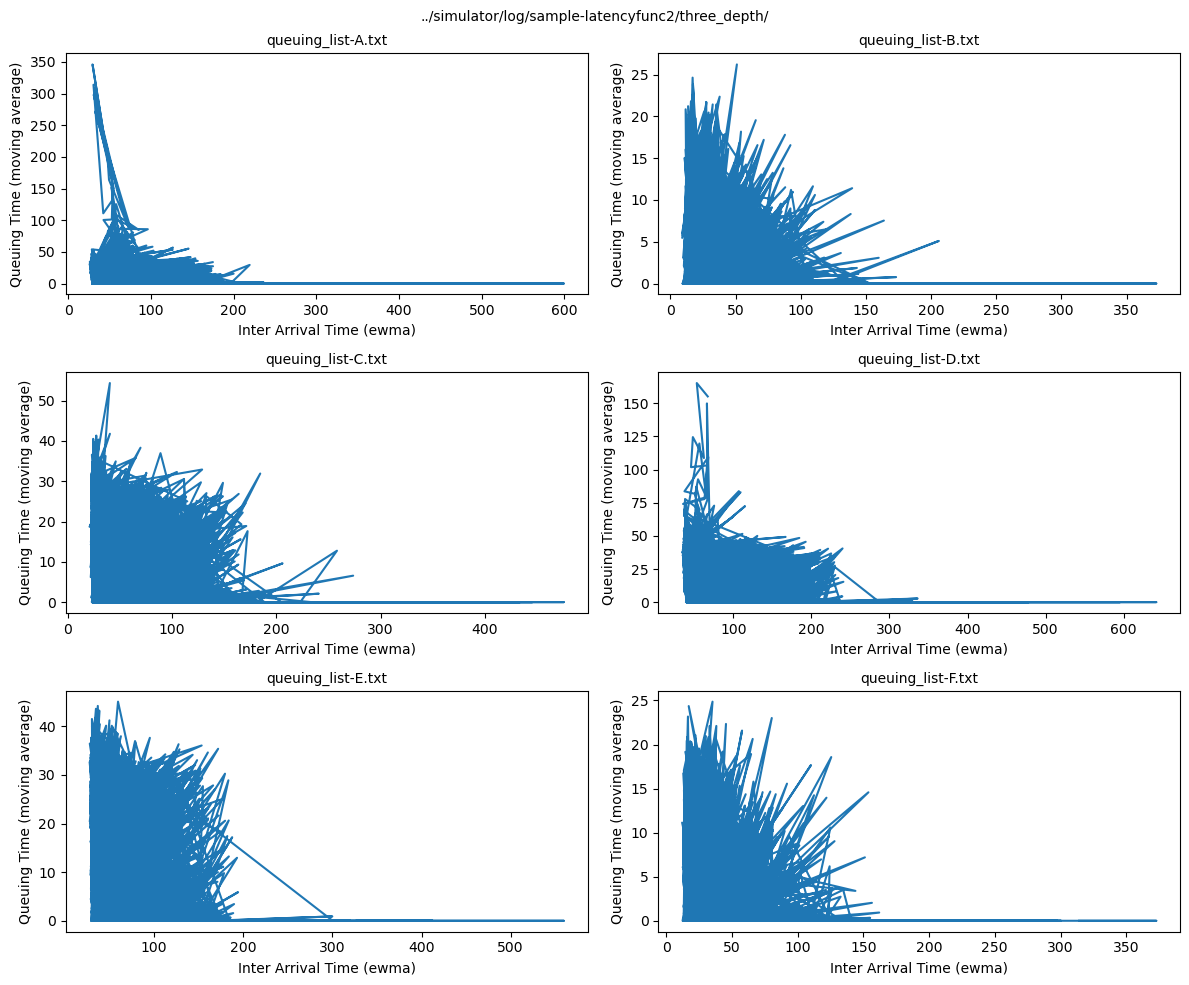

In [265]:
routing = "RoundRobin-heuristic_TE"
# routing = "RoundRobin-LCLB"
# routing = "RoundRobin-MCLB"
common_path="../simulator/log/sample-latencyfunc2/three_depth/"
svc_list = ["A","B","C","D","E","F"]
# svc_list = ["A"]
window_size = 5
fig = plt.figure(figsize=(12, 10))
fig.suptitle(common_path, fontsize=10)
subplot_pos = 1
for svc in svc_list:
    pa_ = common_path + routing + "/queuing_list-"+svc+".txt"
    df, groupby_df = latency_function_df(pa_)
    moving_avg_of_queuing_time = list()
    temp_inter_arrival_time = list()
    for i in range(window_size, len(groupby_df)):
        moving_avg = sum(groupby_df.loc[i-window_size:i, "queuing_time"])/window_size
        moving_avg_of_queuing_time.append(moving_avg)
        temp_inter_arrival_time.append(groupby_df.loc[i, "ewma_inter_arrival_time"])
    ax1 = fig.add_subplot(3, 2, subplot_pos) # (row, col, the position of the current plot)
    # plt.plot(temp_inter_arrival_time, moving_avg_of_queuing_time)
    plt.plot(df["moving_avg_inter_arrival_time"], df["queuing_time"])
    ax1.set_xlabel("Inter Arrival Time (ewma)")#, fontsize=10)
    ax1.set_ylabel("Queuing Time (moving average)")#, fontsize=10)
    # ax1.legend(loc="lower right", fontsize=10)
    ax1.set_title(pa_.split("/")[-1], fontsize=10)
    subplot_pos += 1
fig.tight_layout()
plt.show()
